In [2]:
# import sys
# sys.path.insert(1, './wlcstat/')
import numpy as np
# import scipy.special as sp
# import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
from matplotlib.colors import LogNorm

In [3]:
# load sf mat

# ID = -17.49
# ID = -10.74  #cross 3
# ID = -13.74  #cross 1.5
# ID = -16.74  #cross 0
# ID = -19.74  #cross -1.5
# ID = -22.74  #cross -3

# ID = -21.54  #cross -3
ID = -21.64  #cross -3

settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

[n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],DNA,mu_max=%s.npy"\
                 % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

density_maps = np.load(r"ID=%s_density_maps.npy" % ID, allow_pickle=True)

In [30]:
e_m

array([-1.5, -1.5])

In [4]:
print("v_int: ")
print(v_int)

print(r"phi_c: ")
print(phi_c)

print("mu max, min, del_mu:")
print(mu_max, mu_min, del_mu) 

print("k logspace min, max, tot num:")
print(klog_min, klog_max, klog_num)

v_int: 
[[-3.92  0.  ]
 [ 0.   -3.92]]
phi_c: 
0.6
mu max, min, del_mu:
-5 -9 0.1
k logspace min, max, tot num:
-2.5 -1 30


<Figure size 640x480 with 0 Axes>

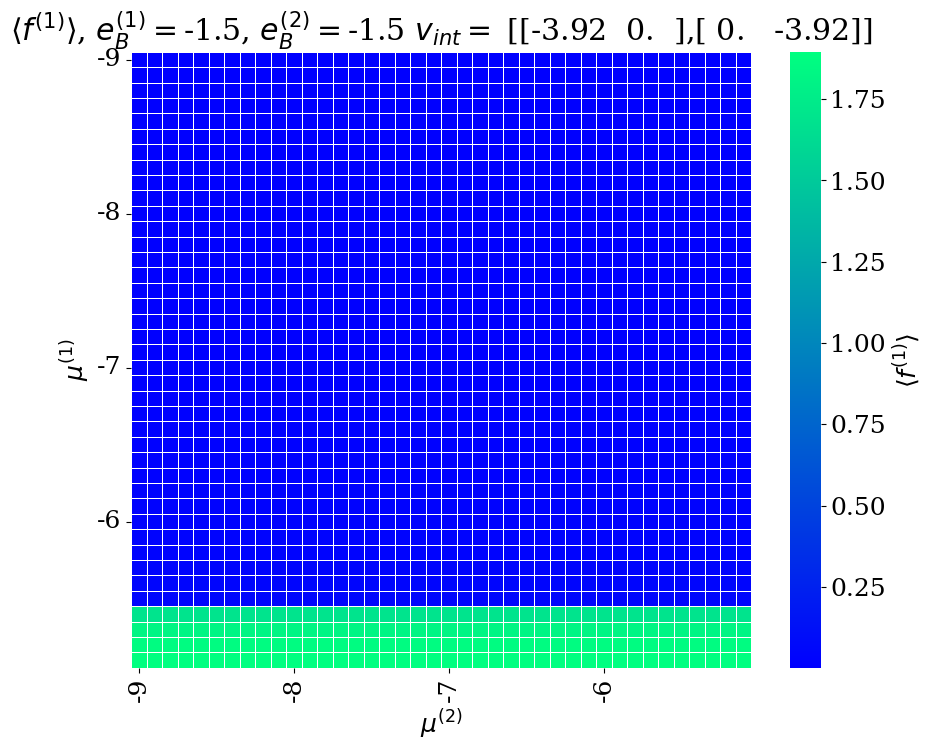

In [8]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

f_gam_soln_arr = density_maps

# #protein 1
ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

ax.set_xticks(ax.get_xticks()[::10])
ax.set_xticklabels(mu2_array[::10].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::10])
ax.set_yticklabels(mu1_array[::10].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
          str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")


plt.show()


<Figure size 640x480 with 0 Axes>

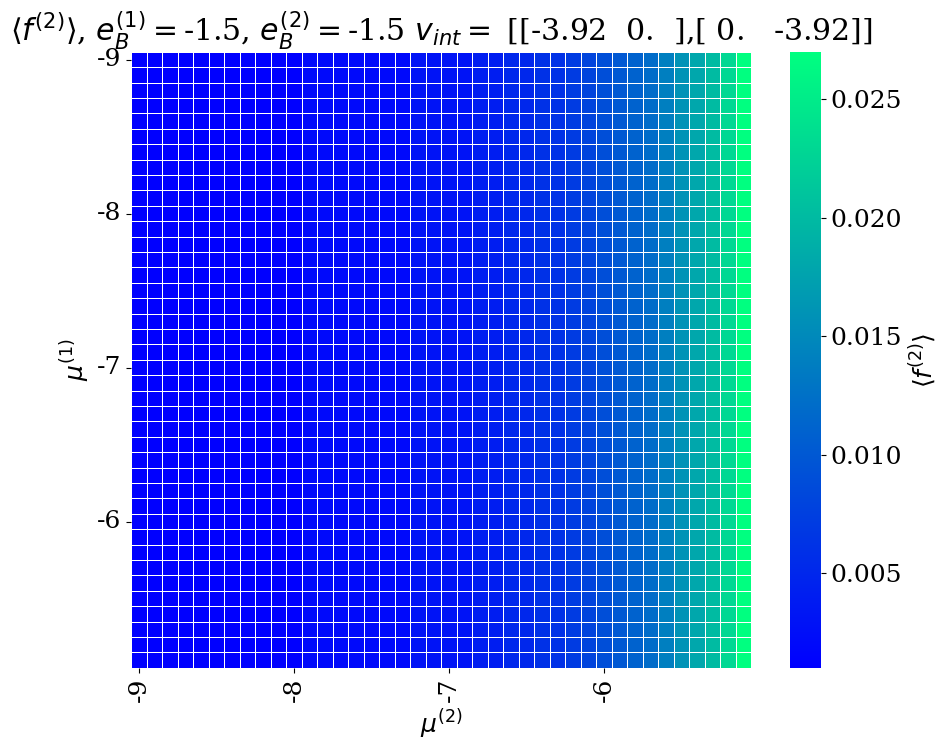

In [28]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])

f_gam_soln_arr = density_maps

#protein 2
ax = sns.heatmap(f_gam_soln_arr[1], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(2)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::10])
ax.set_xticklabels(mu2_array[::10].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::10])
ax.set_yticklabels(mu1_array[::10].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ \langle f^{(2)} \rangle $" +  ", $e_B^{(1)} = $" + \
          str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")



plt.show()


In [6]:
b

106

In [26]:
# stab anal

# poly solv
# chi = 0.00083
# chi = 3/N
# chi = 2/N

# full soln
# chi = 0.00005828
# chi = 0.


# full soln alt solv sf scaling
# chi = 45810.8 / N# 0.00005828 * 500000/24 + 0.01*3.5 + 0.0001*7
chi = 0#10/N
#pokly solv solv sf scaling
# chi = -45810.820605/ N# poly solv
# chi = -4e30/ N# poly solv
# chi = 0#4.820605/ N# poly solv
# chi = 45811.820605/ N# poly solv


min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))


S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_1 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_melt_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigval_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigval_arr_allk_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

# min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)), dtype = object)
# min_eigvec_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])), dtype = object)

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
min_eigvec_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))

k_star_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

A = 1/(b**2) # nm^2
vol_nuc = A*(b**2)

vol_solv = N #1#10000000**3# (4e-10)**3

for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]

        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])
        
#             S2_mat =  s2_mats[i][j][ik] # ORIGINAL

            S2_mat =  s2_mats[i][j][ik].copy()
#             print(S2_mat)
            S2_mat *= N*vol_nuc
            S2_mat[1][1] /= (N*vol_nuc)
            S2_mat[1][1] *= vol_solv

            if phi_c >= 0.999:
                raise Exception("melt!")
                
            
            # FULL SOLUTION 2 reader proteins
            S2_det = np.linalg.det(S2_mat)
#             S2_det_arr[i][j][ik] = S2_det

            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
    #             G2 = N* np.array([[S2_inv[0,0] - 2*chi/N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
    #                [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]/N, S2_inv[2,3] + v_int[0,1]/N],\
    #                [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]/N, S2_inv[3,3] + v_int[1,1]/N]])

#                 G2 = (1/N)* np.array([[S2_inv[0,0] - 2*chi*N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + N*v_int[0,0], S2_inv[2,3] + N*v_int[0,1]],\
#                    [S2_inv[3,0], S2_inv[3,2] + N*v_int[1,0], S2_inv[3,3] + N*v_int[1,1]]])  # ORIGINAL

                G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
        
                val, vec = np.linalg.eigh(G2)
                vec = vec.T
#                 print(vec)
#                 print(vec.T)
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

            # POLY/SOLV only
            S2_mat = np.array([[S2_mat[0,0], 0], [0, S2_mat[1,1]]])

            if phi_c >= 0.999:
                raise Exception("melt!")
            S2_det = np.linalg.det(S2_mat)           
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)

#                 G2 = (1/N)* np.array([S2_inv[0,0] - 2*chi*N + S2_inv[1,1]]) # original
                
                G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])

                val = G2[0]
#                 min_val = np.min(val)            
                min_eigval_arr_ps[i][j][ik] = val


        # all-k analysis
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
            min_eigval_arr_allk[i][j] = minval_allk
            
            min_eigvec_arr_allk[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
            k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
            k_star_arr[i][j] = k_star

            
        min_vals_ps = min_eigval_arr_ps[i][j][:][np.nonzero(min_eigval_arr_ps[i][j][:])] # min eigvals at mu1,mu2 for each k
#         if len(min_vals_ps) != 0:
#             minval_allk = np.min(min_vals_ps) # minimum eigenvalue at mu1,mu2 across all ks
        min_eigval_arr_allk_ps[i][j] = np.min(min_vals_ps)
            
#         min_vals_melt = min_eigval_arr_melt[i][j][:] # min eigvals at mu1,mu2 for each k
#         minval_allk_melt = np.min(min_vals_melt) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_melt[i][j] = minval_allk_melt

        cond_nums = S2_cond_arr_soln_2[i][j][:]
        max_cond_allk = np.max(cond_nums)
        max_cond_arr_allk[i][j] = max_cond_allk
        

# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

<Figure size 640x480 with 0 Axes>

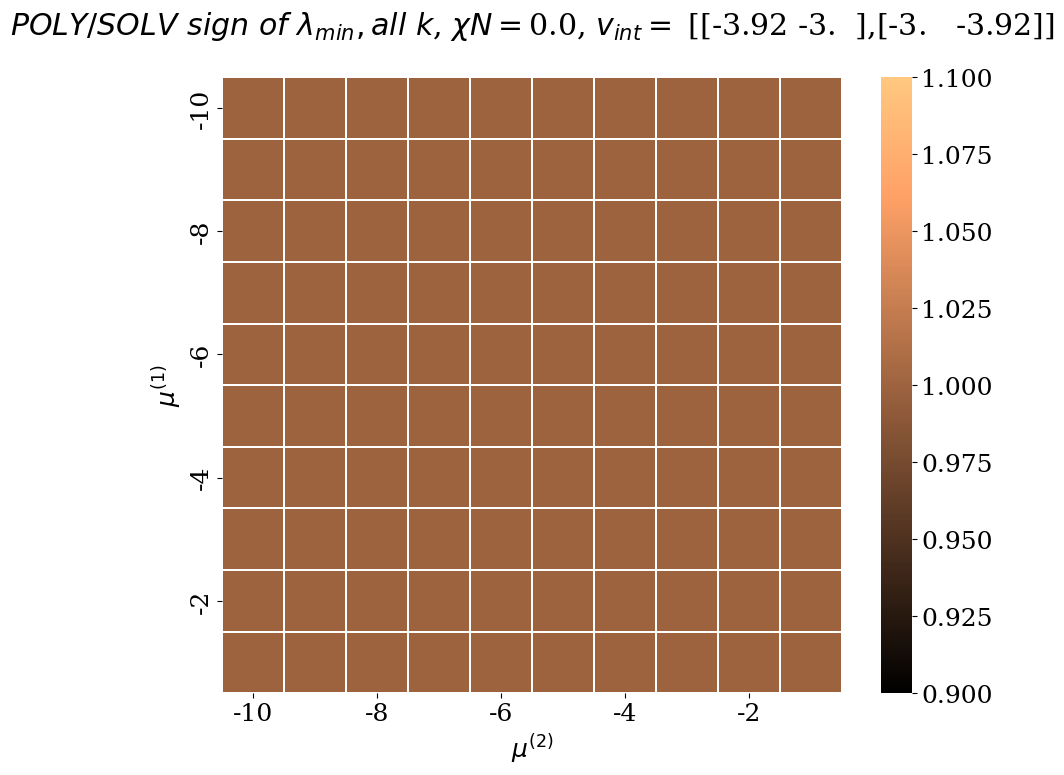

In [27]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk_ps), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ POLY/SOLV \ sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi N = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")


plt.show()


<Figure size 640x480 with 0 Axes>

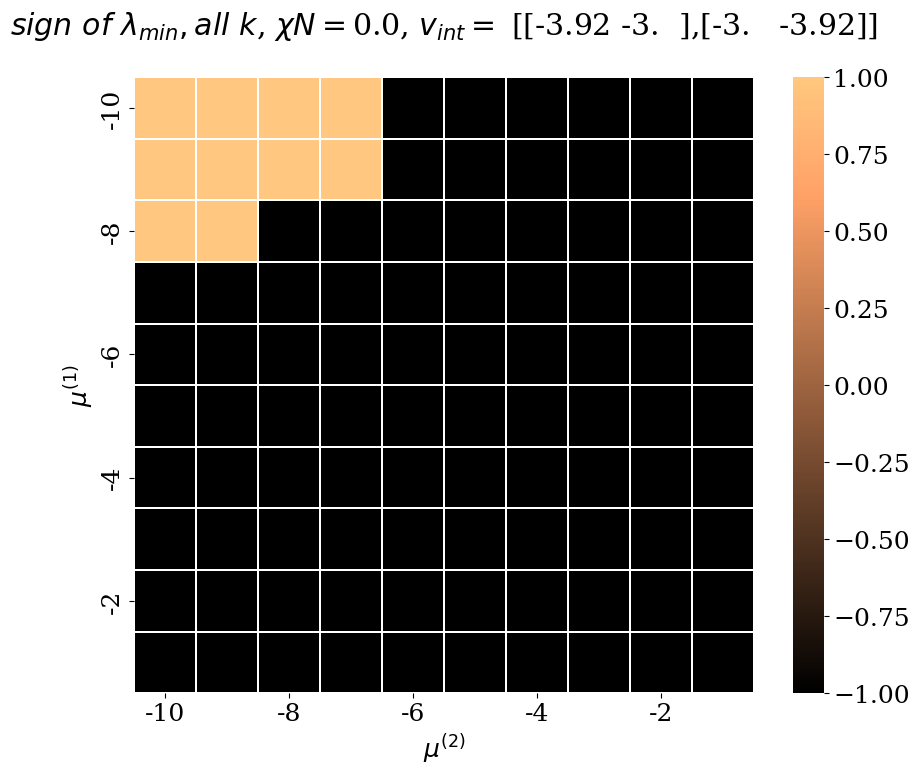

In [28]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi N = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")


plt.show()


<Figure size 640x480 with 0 Axes>

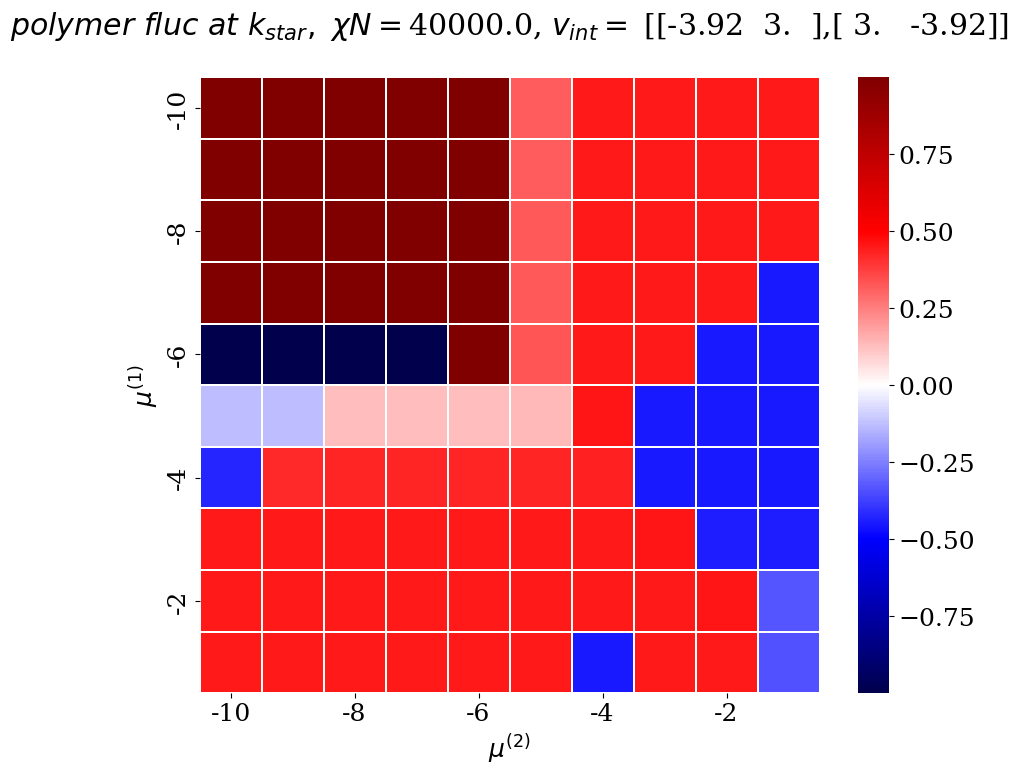

In [8]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(poly_fluc, linewidth=0.25, cmap = "seismic", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ polymer \ fluc \ at \ k_{star}, $" +  " $\chi N = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")


plt.show()


<Figure size 640x480 with 0 Axes>

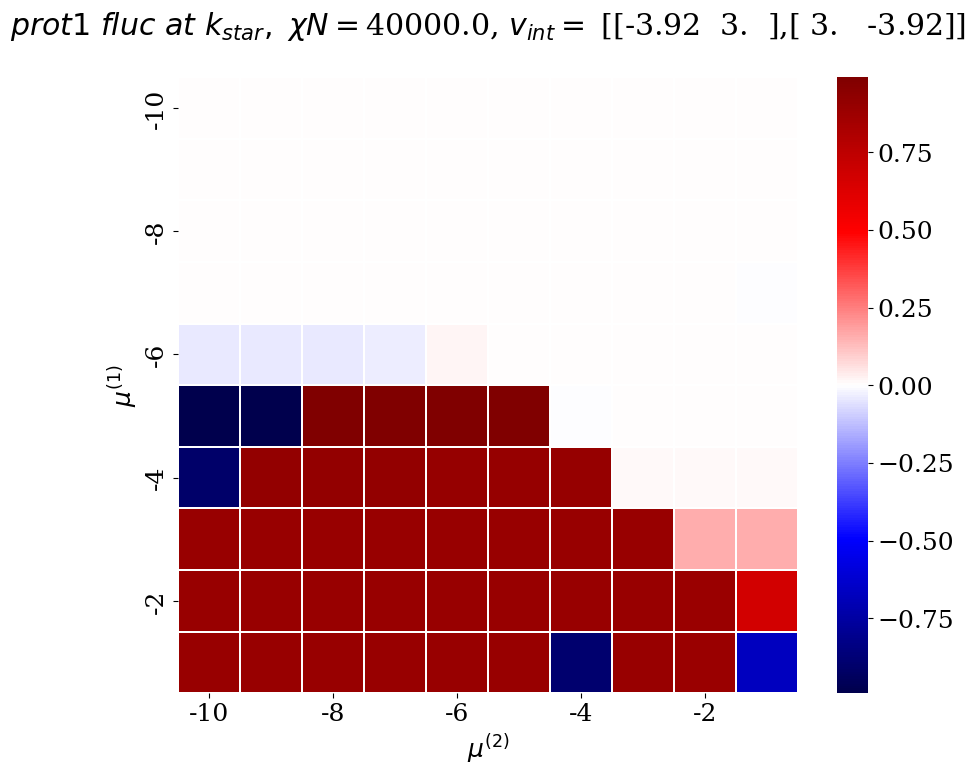

In [9]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(prot1_fluc, linewidth=0.25, cmap = "seismic", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ prot1 \ fluc \ at \ k_{star}, $" +  " $\chi N = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")


plt.show()


<Figure size 640x480 with 0 Axes>

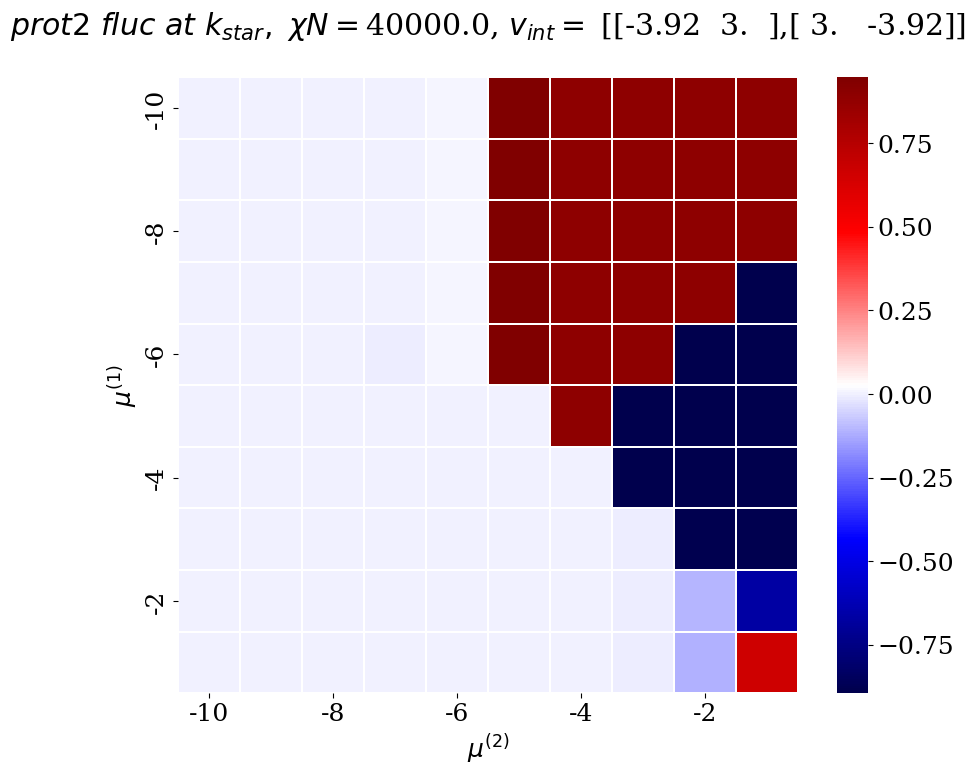

In [10]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(prot2_fluc, linewidth=0.25, cmap = "seismic", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ prot2 \ fluc \ at \ k_{star}, $" +  " $\chi N = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")


plt.show()


<Figure size 640x480 with 0 Axes>

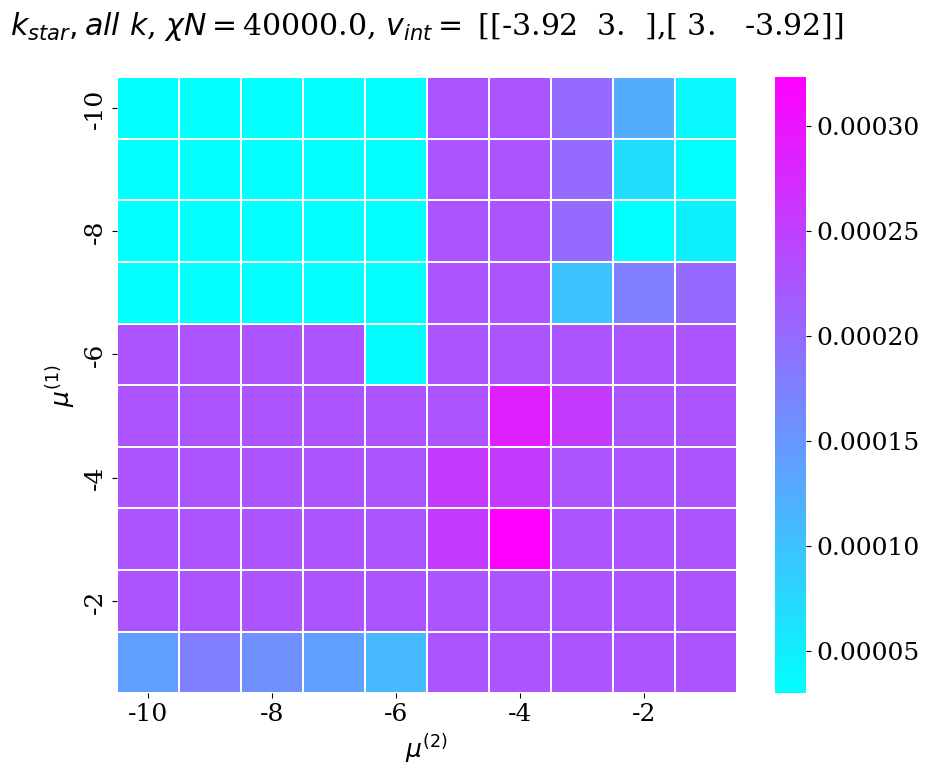

In [11]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(k_star_arr, linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ k_{star}, all \ k$" +  ", $\chi N = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")


plt.show()


<Figure size 640x480 with 0 Axes>

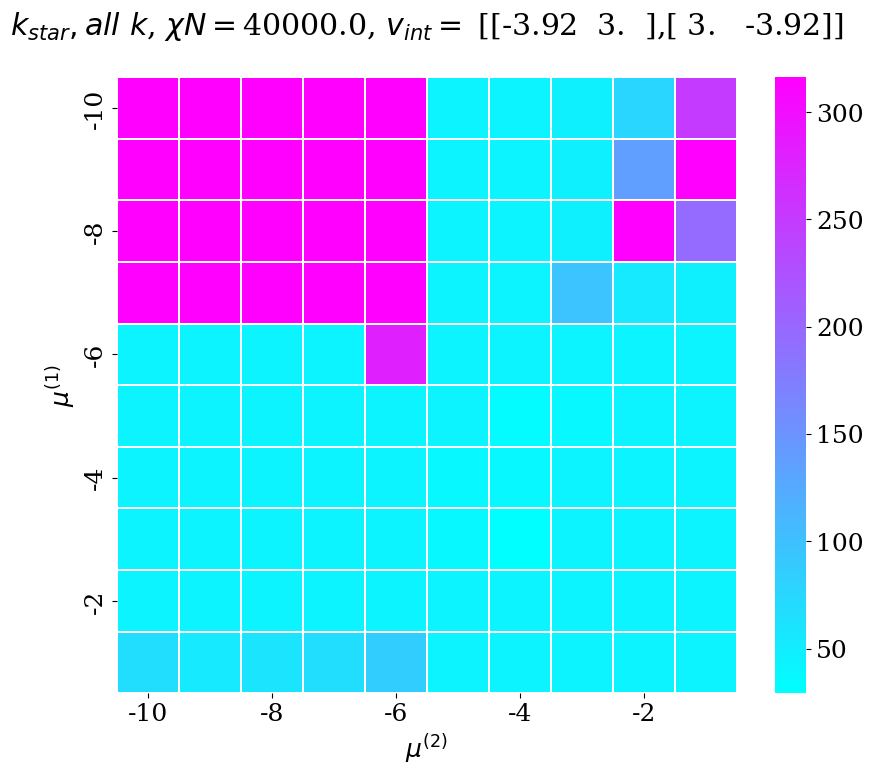

In [12]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(1/(k_star_arr*b), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ k_{star}, all \ k$" +  ", $\chi N = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")


plt.show()


In [13]:
1/(k_vec[-1] * b)
# 1/(2.5e-4 * b)

10.0

<Figure size 640x480 with 0 Axes>

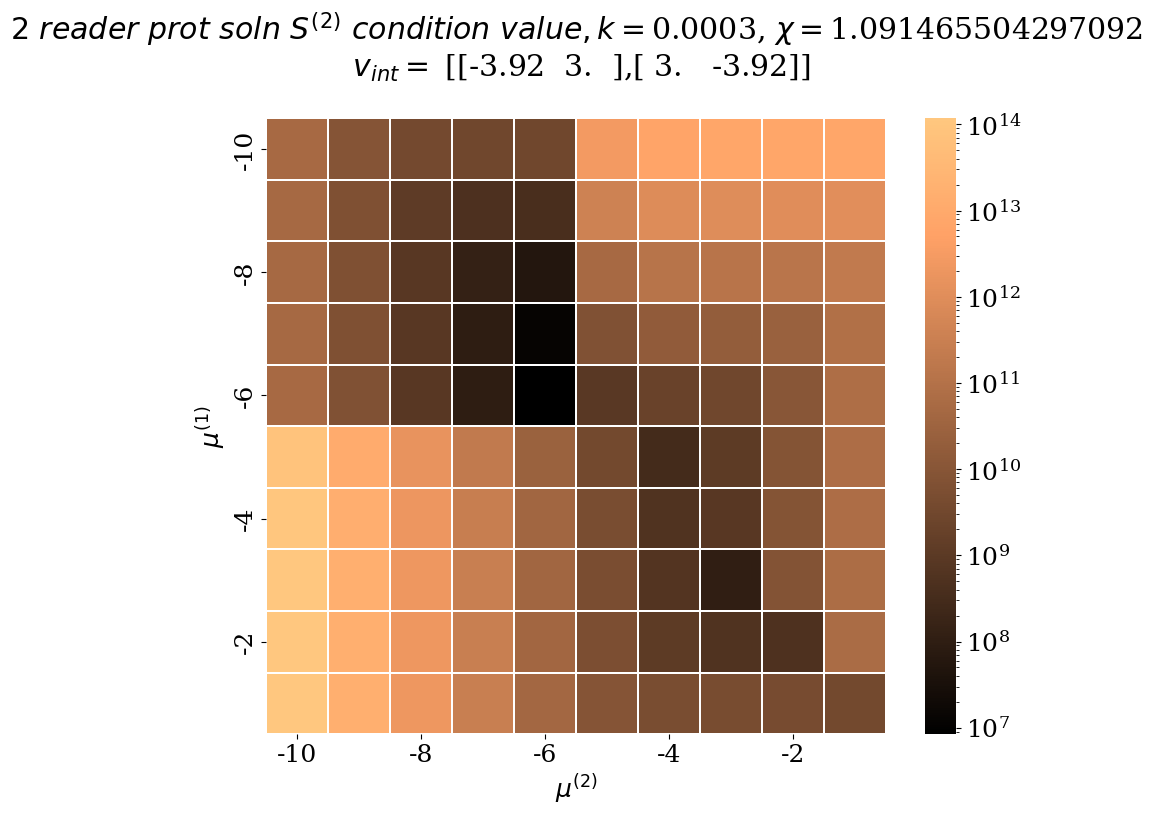

In [14]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
k_ind = 20
ax = sns.heatmap(S2_cond_arr_soln_2[:,:,k_ind], linewidth=0.25, norm = LogNorm(), cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels(mu2_array[::2].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels(mu1_array[::2].astype(np.int64))

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$ 2 \ reader \ prot \ soln \  S^{(2)} \ condition \ value, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
          str(chi)+\
          "\n" +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")

plt.show()


In [15]:
chi*N

40000.0

In [42]:
N

36647.974528301886

In [ ]:
# #density maps
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# # plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 0
# ax = sns.heatmap(np.sign(min_eigval_arr[:,:,k_ind]), linewidth=0.25, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# # ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# # protein 1
# # ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ sign \ of \ \lambda_{min}, k = $" + str(np.round(k_vec[k_ind], 4)) +  ", $\chi = $" + \
#           str(chi) \
#           +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
#           "\n")


# plt.show()


In [9]:
# A = 1/(b**2) # nm^2
# vol_nuc = A*(b**2)

# vol_solv = 1#10000000**3# (4e-10)**3


# ID_array = [-10.74, -13.74, -16.74, -19.74, -22.74]
# ID_array = [-10.74, -16.74, -22.74]

# ID_array = [-15.54, -17.54, -19.54, -21.54] #-6 -9 .2 mu s
ID_array = [-15.64, -17.64, -19.64, -21.64] #-5 -9 .1 mu s

# ID_array = [-10.74, -13.74]#, -16.74, -19.74, -22.74]
density_maps_array = np.zeros(len(ID_array), dtype = object)
for i, ID in enumerate(ID_array):
    density_maps_array[i] = np.load(r"ID=%s_density_maps.npy" % ID, allow_pickle=True)

0
1
2
3


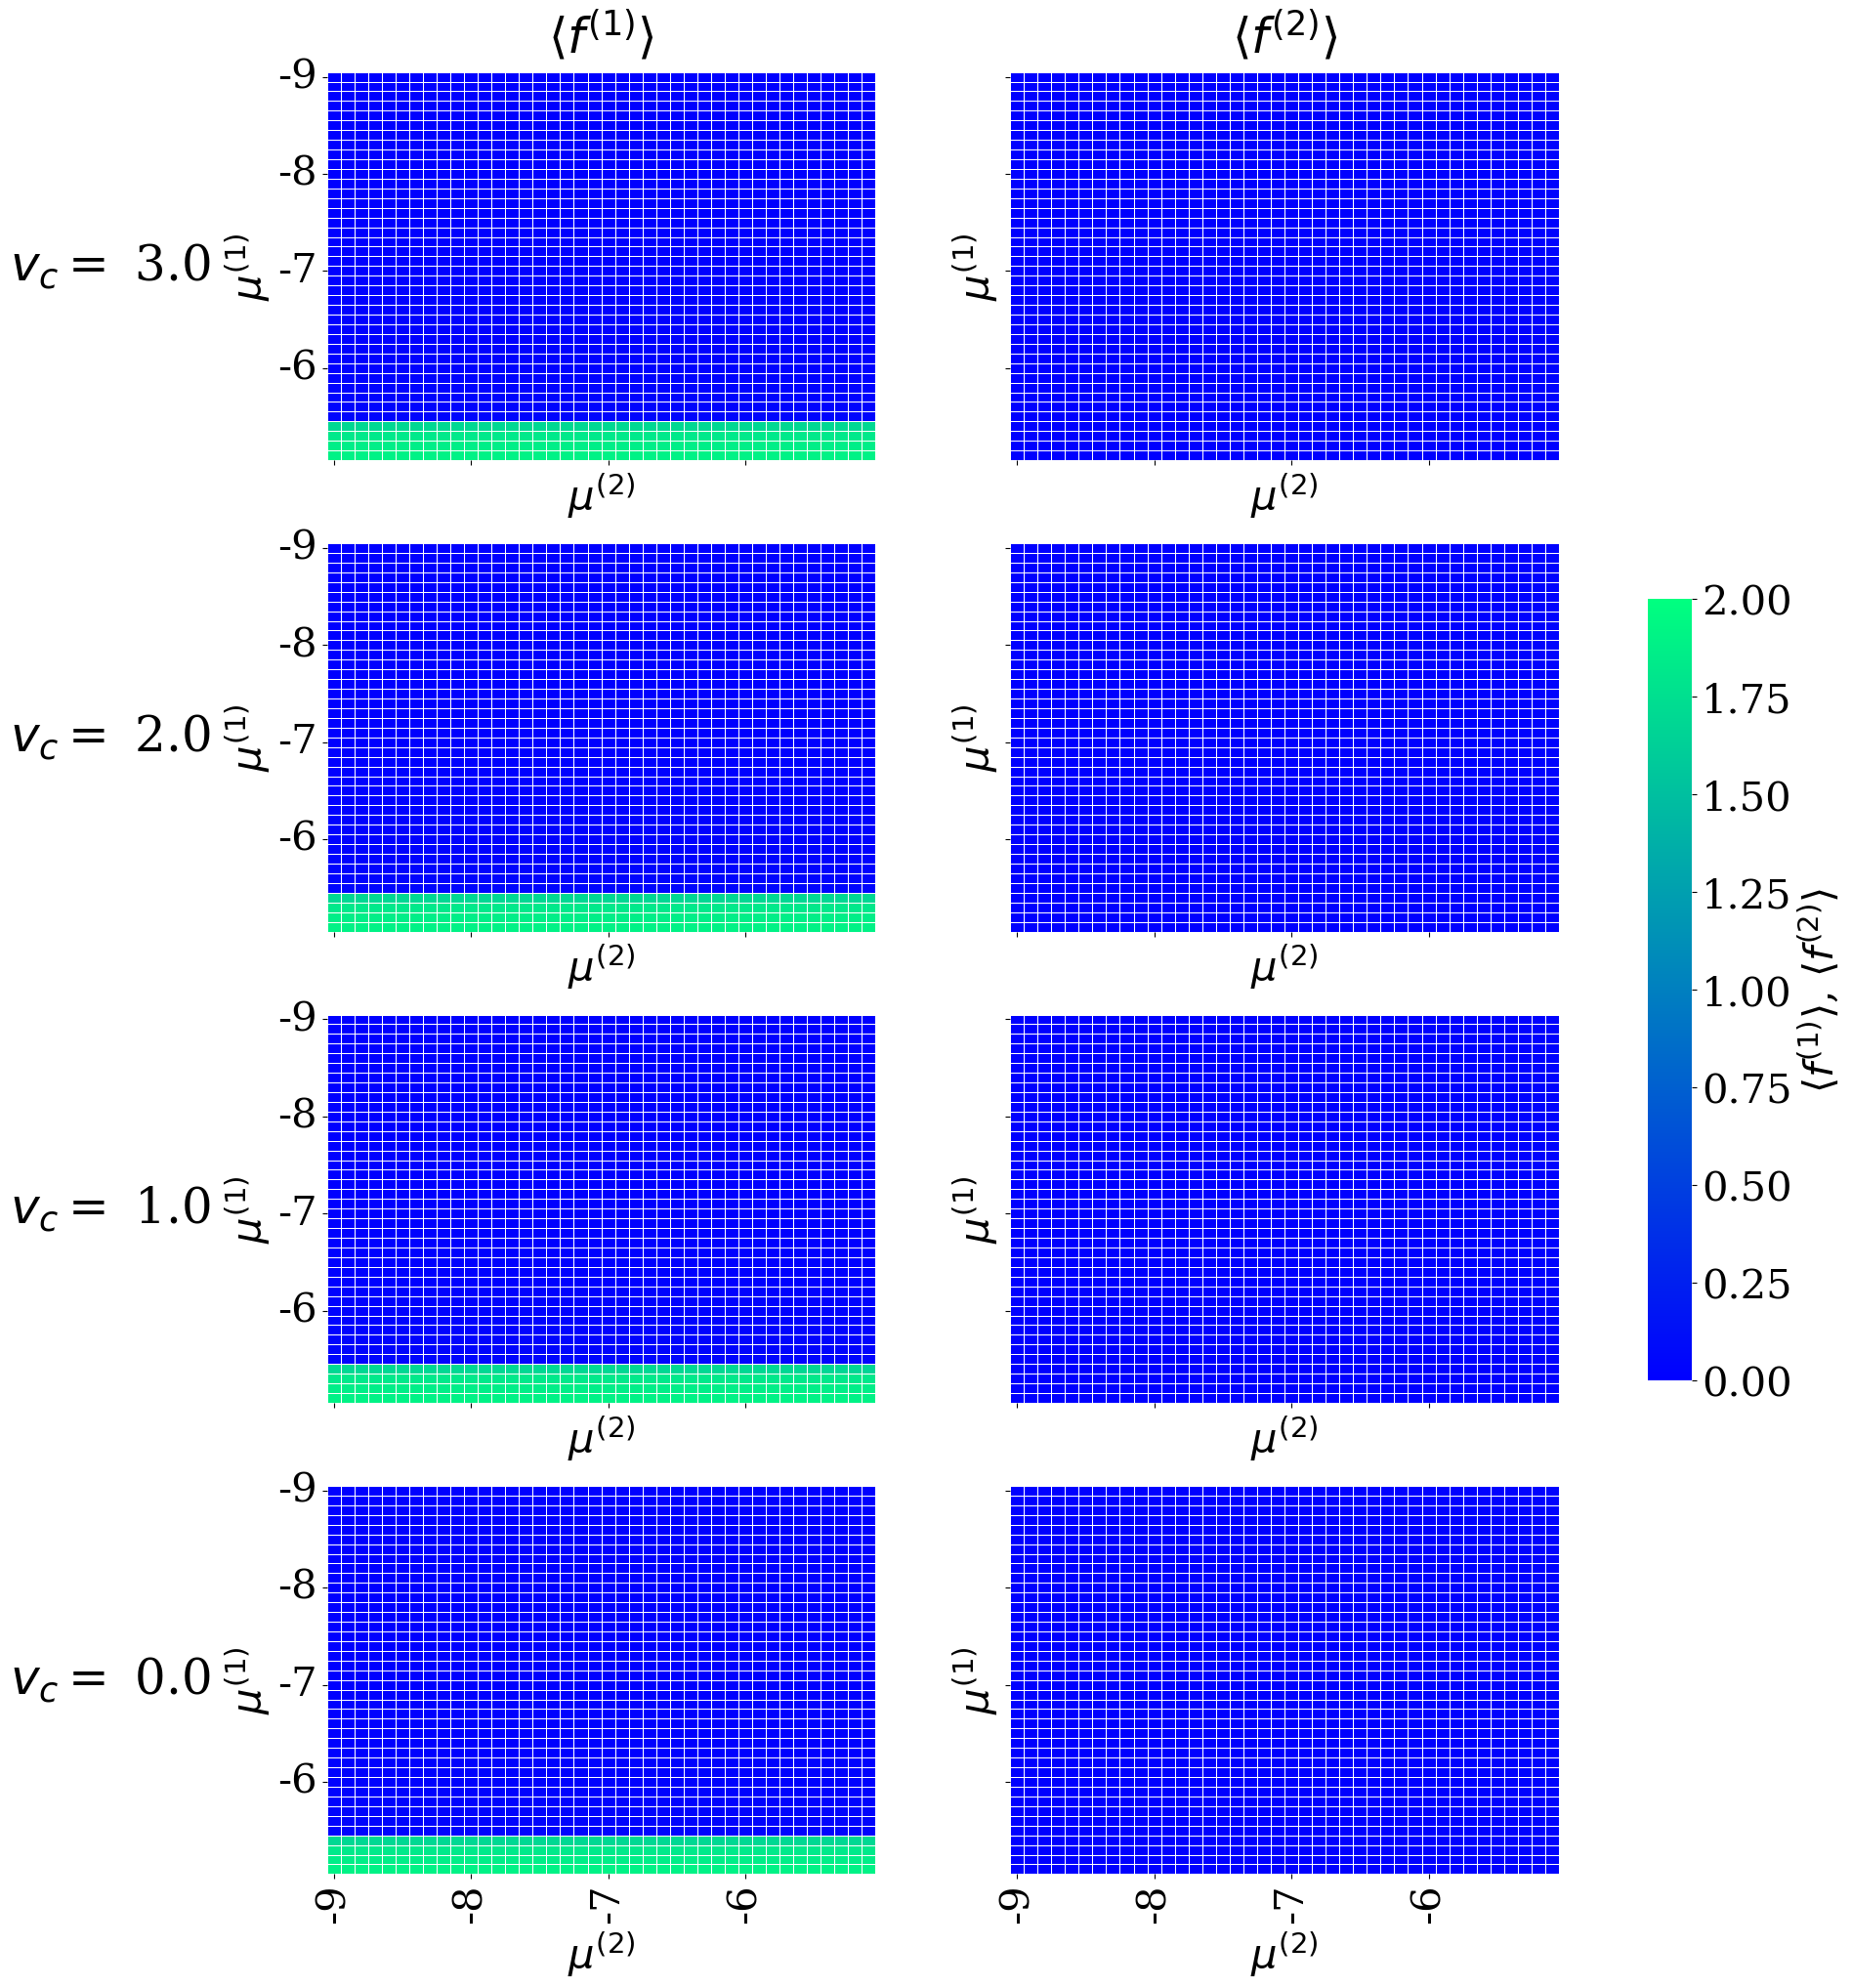

In [41]:
# fig, axs = plt.subplots(len(ID_array), 1, figsize=(5*2,17*2), sharex=True, sharey = True)
fig, axs = plt.subplots(len(ID_array), 2, figsize=(15,20), sharex=True, sharey = True)
# fig, axs = plt.subplots(3,2, figsize=(15, 18), sharex=True, sharey = True)

# fig = plt.figure()
# plt.figure(figsize=(10,8))
fig.tight_layout()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 30}
plt.rc('font', **font)
# fig.suptitle(r"$ \langle f^{(1)} \rangle $", y = 1.03)#\
#              +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]), y = 1.03)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .3, .03, .4])
# for i, ax in enumerate(axs.flat):
v_c_list = np.zeros(len(ID_array))
for i in range(len(ID_array)):
#     ax 
#     if i == 5:
#         ax.axis("off")
#         ax.grid(False)
#         ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#         break
    print(i)
    ID = ID_array[i]
    settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

    [chrom, [klog_min, klog_max, klog_num]] = settings

    [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    
    v_c_list[i] = v_int[0][1]

    mu1_array = np.arange(mu_min, mu_max, del_mu)
    mu2_array = np.arange(mu_min, mu_max, del_mu)

    k_vec = np.logspace(klog_min, klog_max, klog_num) / b
    for j in range(2):
        ax = axs[i][j]
        titl = ""
        if j == 0:
            titl = r'$ \langle f^{(1)} \rangle $'
        elif j == 1:
            titl = r'$ \langle f^{(2)} \rangle $'
        ax_titl = r'$ \langle f^{(1)} \rangle $, $ \langle f^{(2)} \rangle $'
    #     sns.heatmap(density_maps_array[i][0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'}, ax = ax)
        sns.heatmap(density_maps_array[i][j], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array,\
                    cbar=i == 0,
                    vmin=0, vmax=2,
                    cbar_ax=None if i else cbar_ax, cbar_kws={'label': ax_titl }, ax = ax)

#         ax.set_xticks(ax.get_xticks()[::2])
#         ax.set_xticklabels(mu2_array[::2].astype(np.int64))  
#         ax.set_yticks(ax.get_yticks()[::2])
#         ax.set_yticklabels(mu1_array[::2].astype(np.int64))    
        ax.set_xticks(ax.get_xticks()[::10])
        ax.set_xticklabels(mu2_array[::10].astype(np.int64))  
        ax.set_yticks(ax.get_yticks()[::10])
        ax.set_yticklabels(mu1_array[::10].astype(np.int64))   

# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel("$\mu^{(2)}$")
# plt.ylabel("$\mu^{(1)}$")
# # plt.xlabel("$\mu^{(2)}$")

dens_tits = [r'$ \langle f^{(1)} \rangle $', r'$ \langle f^{(2)} \rangle $']
plt.setp(axs.flat, xlabel="$\mu^{(2)}$", ylabel="$\mu^{(1)}$")
rows = ['$v_c = $ {}'.format(v_cross) for v_cross in v_c_list]

cols = [tit for tit in dens_tits]
pad = 5 # in points
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1.03), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.show()

0
1
2
3


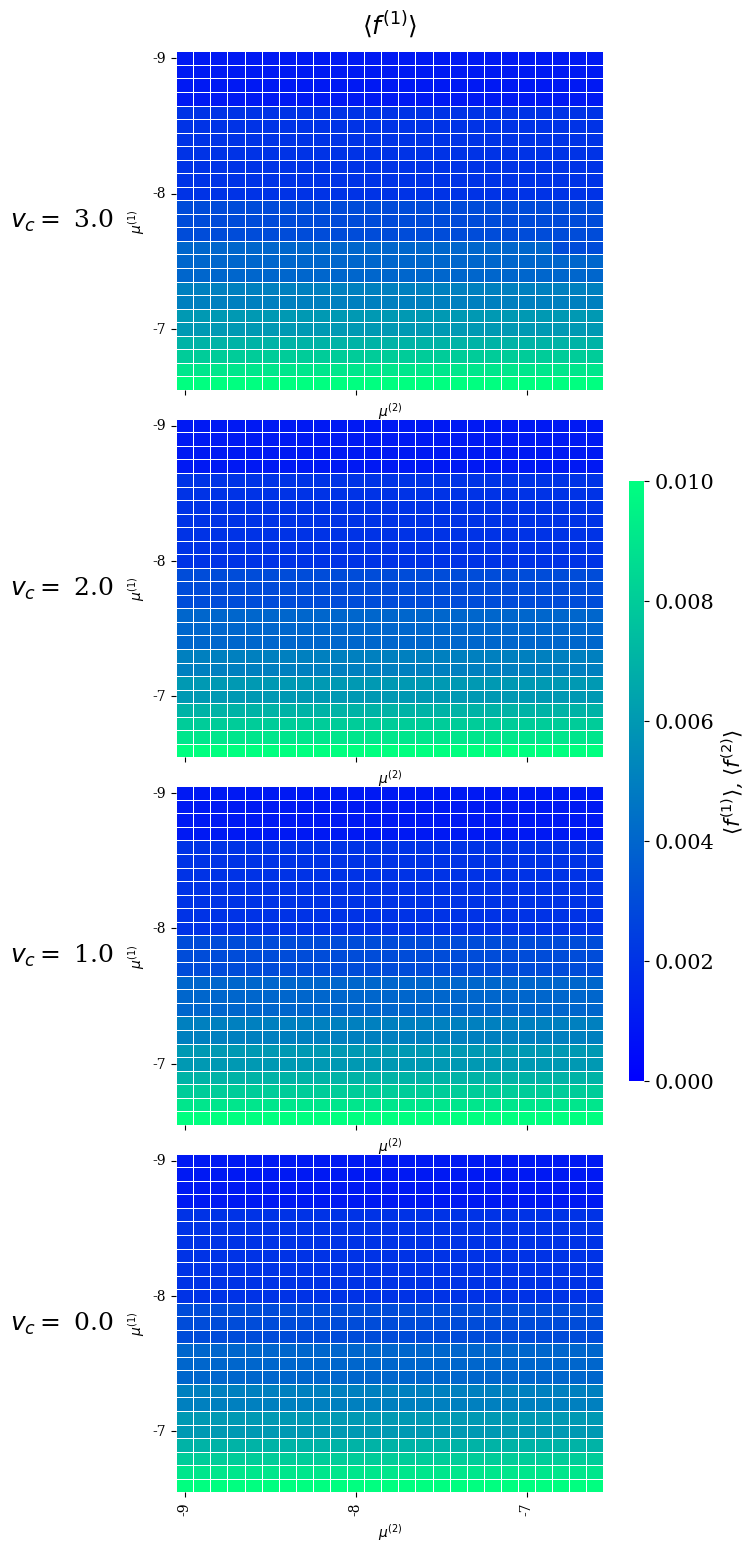

In [72]:
dens_range = 25
j = 0
cur_max = 0
for i in range(len(ID_array)):
    new_max = np.max(density_maps_array[i][j][0:dens_range, 0:dens_range])
    if new_max > cur_max:
        cur_max = new_max

# fig, axs = plt.subplots(len(ID_array), 1, figsize=(5*2,17*2), sharex=True, sharey = True)
fig, axs = plt.subplots(len(ID_array), 1, figsize=(5,15), sharex=True, sharey = True)
# fig, axs = plt.subplots(3,2, figsize=(15, 18), sharex=True, sharey = True)

# fig = plt.figure()
# plt.figure(figsize=(10,8))
fig.tight_layout()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 15}
plt.rc('font', **font)
# fig.suptitle(r"$ \langle f^{(1)} \rangle $", y = 1.03)#\
#              +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]), y = 1.03)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .3, .03, .4])
# for i, ax in enumerate(axs.flat):
v_c_list = np.zeros(len(ID_array))
for i in range(len(ID_array)):
#     ax 
#     if i == 5:
#         ax.axis("off")
#         ax.grid(False)
#         ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#         break
    print(i)
    ID = ID_array[i]
    settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

    [chrom, [klog_min, klog_max, klog_num]] = settings

    [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    
    v_c_list[i] = v_int[0][1]

    mu1_array = np.arange(mu_min, mu_max, del_mu)
    mu2_array = np.arange(mu_min, mu_max, del_mu)

    k_vec = np.logspace(klog_min, klog_max, klog_num) / b
#     for j in range(2):
    ax = axs[i]
    titl = ""
    if j == 0:
        titl = r'$ \langle f^{(1)} \rangle $'
    elif j == 1:
        titl = r'$ \langle f^{(2)} \rangle $'
    ax_titl = r'$ \langle f^{(1)} \rangle $, $ \langle f^{(2)} \rangle $'
#     sns.heatmap(density_maps_array[i][0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'}, ax = ax)
    sns.heatmap(density_maps_array[i][j][0:dens_range, 0:dens_range], linewidth=0.5, cmap = "winter", xticklabels=mu2_array[:dens_range], yticklabels=mu1_array[:dens_range],\
                cbar=i == 0,
                vmin=0, vmax=cur_max,
                cbar_ax=None if i else cbar_ax, cbar_kws={'label': ax_titl }, ax = ax)

#         ax.set_xticks(ax.get_xticks()[::2])
#         ax.set_xticklabels(mu2_array[::2].astype(np.int64))  
#         ax.set_yticks(ax.get_yticks()[::2])
#         ax.set_yticklabels(mu1_array[::2].astype(np.int64))    
    ax.set_xticks(ax.get_xticks()[:dens_range:10])
    ax.set_xticklabels(mu2_array[:dens_range:10].astype(np.int64))  
    ax.set_yticks(ax.get_yticks()[:dens_range:10])
    ax.set_yticklabels(mu1_array[:dens_range:10].astype(np.int64))   

# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel("$\mu^{(2)}$")
# plt.ylabel("$\mu^{(1)}$")
# # plt.xlabel("$\mu^{(2)}$")

dens_tits = [r'$ \langle f^{(1)} \rangle $', r'$ \langle f^{(2)} \rangle $']
plt.setp(axs.flat, xlabel="$\mu^{(2)}$", ylabel="$\mu^{(1)}$")
rows = ['$v_c = $ {}'.format(v_cross) for v_cross in v_c_list]

cols = [dens_tits[j]]#[tit for tit in dens_tits]
pad = 5 # in points
for ax, col in zip(axs, cols):
    ax.annotate(col, xy=(0.5, 1.03), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs, rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.show()

0
1
2
3


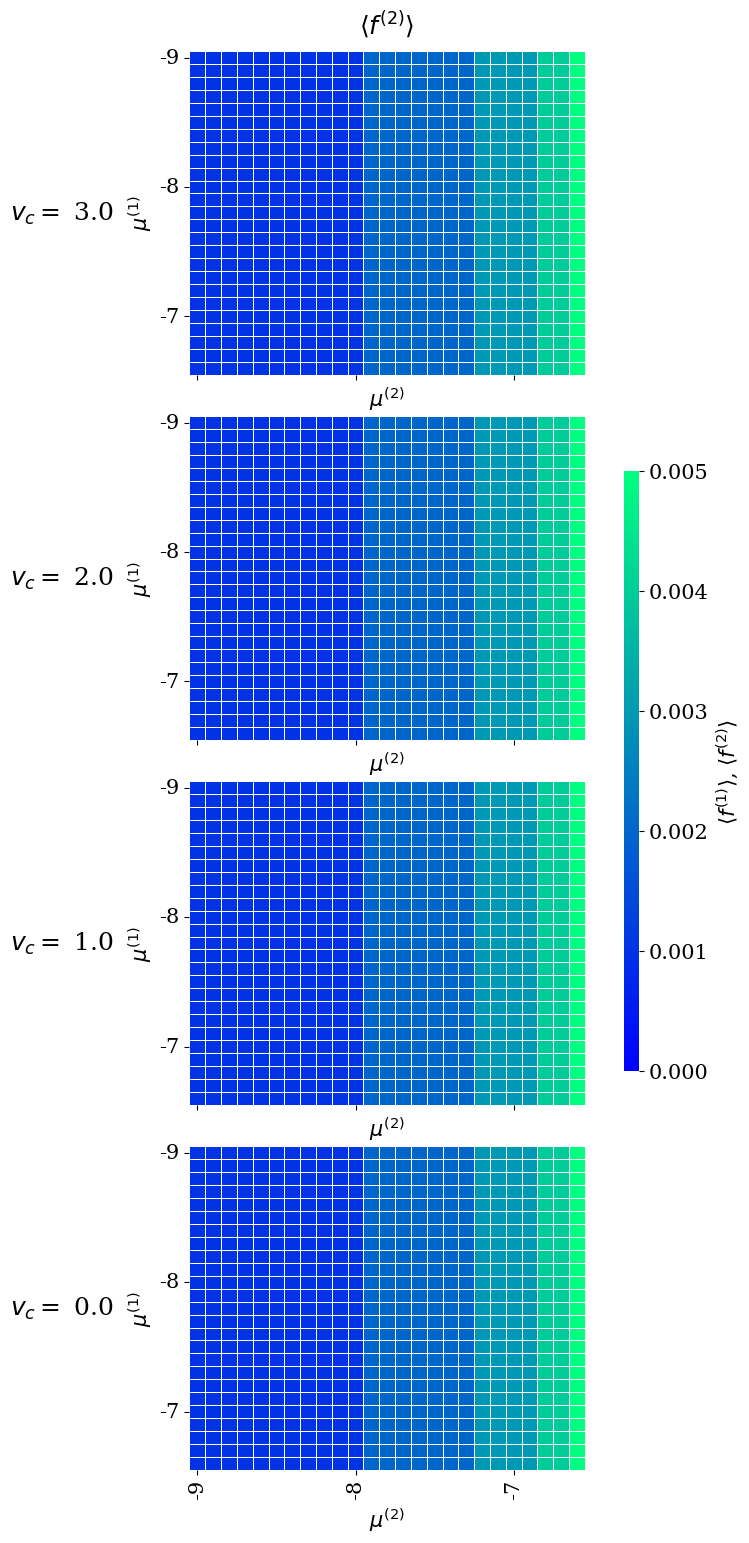

In [73]:
dens_range = 25
j = 1
cur_max = 0
for i in range(len(ID_array)):
    new_max = np.max(density_maps_array[i][j][0:dens_range, 0:dens_range])
    if new_max > cur_max:
        cur_max = new_max

# fig, axs = plt.subplots(len(ID_array), 1, figsize=(5*2,17*2), sharex=True, sharey = True)
fig, axs = plt.subplots(len(ID_array), 1, figsize=(5,15), sharex=True, sharey = True)
# fig, axs = plt.subplots(3,2, figsize=(15, 18), sharex=True, sharey = True)

# fig = plt.figure()
# plt.figure(figsize=(10,8))
fig.tight_layout()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 15}
plt.rc('font', **font)
# fig.suptitle(r"$ \langle f^{(1)} \rangle $", y = 1.03)#\
#              +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]), y = 1.03)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .3, .03, .4])
# for i, ax in enumerate(axs.flat):
v_c_list = np.zeros(len(ID_array))
for i in range(len(ID_array)):
#     ax 
#     if i == 5:
#         ax.axis("off")
#         ax.grid(False)
#         ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#         break
    print(i)
    ID = ID_array[i]
    settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

    [chrom, [klog_min, klog_max, klog_num]] = settings

    [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    
    v_c_list[i] = v_int[0][1]

    mu1_array = np.arange(mu_min, mu_max, del_mu)
    mu2_array = np.arange(mu_min, mu_max, del_mu)

    k_vec = np.logspace(klog_min, klog_max, klog_num) / b
#     for j in range(2):
    ax = axs[i]
    titl = ""
    if j == 0:
        titl = r'$ \langle f^{(1)} \rangle $'
    elif j == 1:
        titl = r'$ \langle f^{(2)} \rangle $'
    ax_titl = r'$ \langle f^{(1)} \rangle $, $ \langle f^{(2)} \rangle $'
#     sns.heatmap(density_maps_array[i][0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'}, ax = ax)
    sns.heatmap(density_maps_array[i][j][0:dens_range, 0:dens_range], linewidth=0.5, cmap = "winter", xticklabels=mu2_array[:dens_range], yticklabels=mu1_array[:dens_range],\
                cbar=i == 0,
                vmin=0, vmax=cur_max,
                cbar_ax=None if i else cbar_ax, cbar_kws={'label': ax_titl }, ax = ax)

#         ax.set_xticks(ax.get_xticks()[::2])
#         ax.set_xticklabels(mu2_array[::2].astype(np.int64))  
#         ax.set_yticks(ax.get_yticks()[::2])
#         ax.set_yticklabels(mu1_array[::2].astype(np.int64))    
    ax.set_xticks(ax.get_xticks()[:dens_range:10])
    ax.set_xticklabels(mu2_array[:dens_range:10].astype(np.int64))  
    ax.set_yticks(ax.get_yticks()[:dens_range:10])
    ax.set_yticklabels(mu1_array[:dens_range:10].astype(np.int64))   

# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel("$\mu^{(2)}$")
# plt.ylabel("$\mu^{(1)}$")
# # plt.xlabel("$\mu^{(2)}$")

dens_tits = [r'$ \langle f^{(1)} \rangle $', r'$ \langle f^{(2)} \rangle $']
plt.setp(axs.flat, xlabel="$\mu^{(2)}$", ylabel="$\mu^{(1)}$")
rows = ['$v_c = $ {}'.format(v_cross) for v_cross in v_c_list]

cols = [dens_tits[j]]#[tit for tit in dens_tits]
pad = 5 # in points
for ax, col in zip(axs, cols):
    ax.annotate(col, xy=(0.5, 1.03), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs, rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.show()

In [15]:

def calc_plots(chrom, k_vec, s2_mats, chi):
    [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

    mu1_array = np.arange(mu_min, mu_max, del_mu)
    mu2_array = np.arange(mu_min, mu_max, del_mu)
    
    S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

    max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

    min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
    min_eigval_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

    min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
    min_eigvec_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))

    k_star_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

    
    A = 1/(b**2) # nm^2
    vol_nuc = A*(b**2)

    vol_solv = N# 1#10000000**3# (4e-10)**3
    
    for i, mu1 in enumerate(mu1_array[:]):
        for j, mu2 in enumerate(mu2_array[:]):
    #         if mu1 == mu2:
    #             continue
            mu = [mu1, mu2]

            for ik, k in enumerate(k_vec):
    #             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
    #                             [0, ss*N**2, 0, 0], \
    #                             [cg1[0], 0, g1g1[0], g1g2[0]],\
    #                             [cg2[0], 0, g2g1[0], g2g2[0]]])

#                 S2_mat =  s2_mats[i][j][ik] # ORIGINAL


                S2_mat =  s2_mats[i][j][ik].copy()
    #             print(S2_mat)
                S2_mat *= N*vol_nuc
                S2_mat[1][1] /= (N*vol_nuc)
                S2_mat[1][1] *= vol_solv
            
                if phi_c >= 0.999:
                    raise Exception("melt!")


                # FULL SOLUTION 2 reader proteins
                S2_det = np.linalg.det(S2_mat)
    #             S2_det_arr[i][j][ik] = S2_det

                S2_cond = np.linalg.cond(S2_mat)
                S2_cond_arr_soln_2[i][j][ik] = S2_cond


                if S2_det != 0:# and S2_cond < 1e10:
                    S2_inv = np.linalg.inv(S2_mat)

#                     G2 = (1/(2*N))* np.array([[S2_inv[0,0] - 2*chi*N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                        [S2_inv[2,0], S2_inv[2,2] + N*v_int[0,0], S2_inv[2,3] + N*v_int[0,1]],\
#                        [S2_inv[3,0], S2_inv[3,2] + N*v_int[1,0], S2_inv[3,3] + N*v_int[1,1]]]) # ORIGINAL

                    G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                       [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
                       [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])

                    val, vec = np.linalg.eigh(G2)
                    vec = vec.T 
                    min_val = np.min(val)            
                    min_eigval_arr[i][j][ik] = min_val
                    min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]


            # all-k analysis
            min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k

            min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
            if len(min_vals) != 0:
                minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
                min_eigval_arr_allk[i][j] = minval_allk

                min_eigvec_arr_allk[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects

                k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
                k_star_arr[i][j] = k_star

            cond_nums = S2_cond_arr_soln_2[i][j][:]
            max_cond_allk = np.max(cond_nums)
            max_cond_arr_allk[i][j] = max_cond_allk


    # setting all non-decomposed/ separated systems to 0 
    poly_fluc = min_eigvec_arr_allk[:,:,0]
    poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

    prot1_fluc = min_eigvec_arr_allk[:,:,1]
    prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

    prot2_fluc = min_eigvec_arr_allk[:,:,2]
    prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0
    
    k_star_arr[np.where(np.sign(min_eigval_arr_allk) == 1) ] = np.nan
    
    return min_eigval_arr_allk, k_star_arr, poly_fluc, prot1_fluc, prot2_fluc

def create_plot_lists(ID_list, chi_list):
    spinodal_plots = np.zeros((len(ID_list), len(chi_list)), dtype = object)
    k_star_plots = np.zeros((len(ID_list), len(chi_list)), dtype = object)
    poly_fluc_plots = np.zeros((len(ID_list), len(chi_list)), dtype = object)
    prot1_fluc_plots = np.zeros((len(ID_list), len(chi_list)), dtype = object)
    prot2_fluc_plots = np.zeros((len(ID_list), len(chi_list)), dtype = object)
    for i, ID in enumerate(ID_list):
        # load ID list
        settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

        [chrom, [klog_min, klog_max, klog_num]] = settings

        [n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

        mu1_array = np.arange(mu_min, mu_max, del_mu)
        mu2_array = np.arange(mu_min, mu_max, del_mu)

        k_vec = np.logspace(klog_min, klog_max, klog_num) / b

        s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],DNA,mu_max=%s.npy"\
                         % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

        density_maps = np.load(r"ID=%s_density_maps.npy" % ID, allow_pickle=True)
        for j,chi in enumerate(chi_list):
            min_eigval_arr_allk, k_star_arr, poly_fluc, prot1_fluc, prot2_fluc = calc_plots(chrom, k_vec, s2_mats, chi)
            
            spinodal_plots[i][j] = min_eigval_arr_allk
            k_star_plots[i][j] = k_star_arr
            poly_fluc_plots[i][j] = poly_fluc
            prot1_fluc_plots[i][j] = prot1_fluc
            prot2_fluc_plots[i][j] = prot2_fluc
            
            
    return spinodal_plots, k_star_plots, poly_fluc_plots, prot1_fluc_plots, prot2_fluc_plots
            # gen spinodal
            # add to spinodal plots

In [16]:
%%time
ID_list = ID_array#[-10.74, -16.74, -22.74]
# chi_list = [-20000/N, 0, 20000/N]
chi_list = [-2/N, 0, 2/N]

chi_list = [-4/N, 0, 4/N]
# chi_val = 45810.8#2e5
# chi_list = [-chi_val/N , 0 , chi_val/N]
spins, k_stars, poly_flucs, prot1_flucs, prot2_flucs = create_plot_lists(ID_list, chi_list)

In [17]:
del_mu

0.1

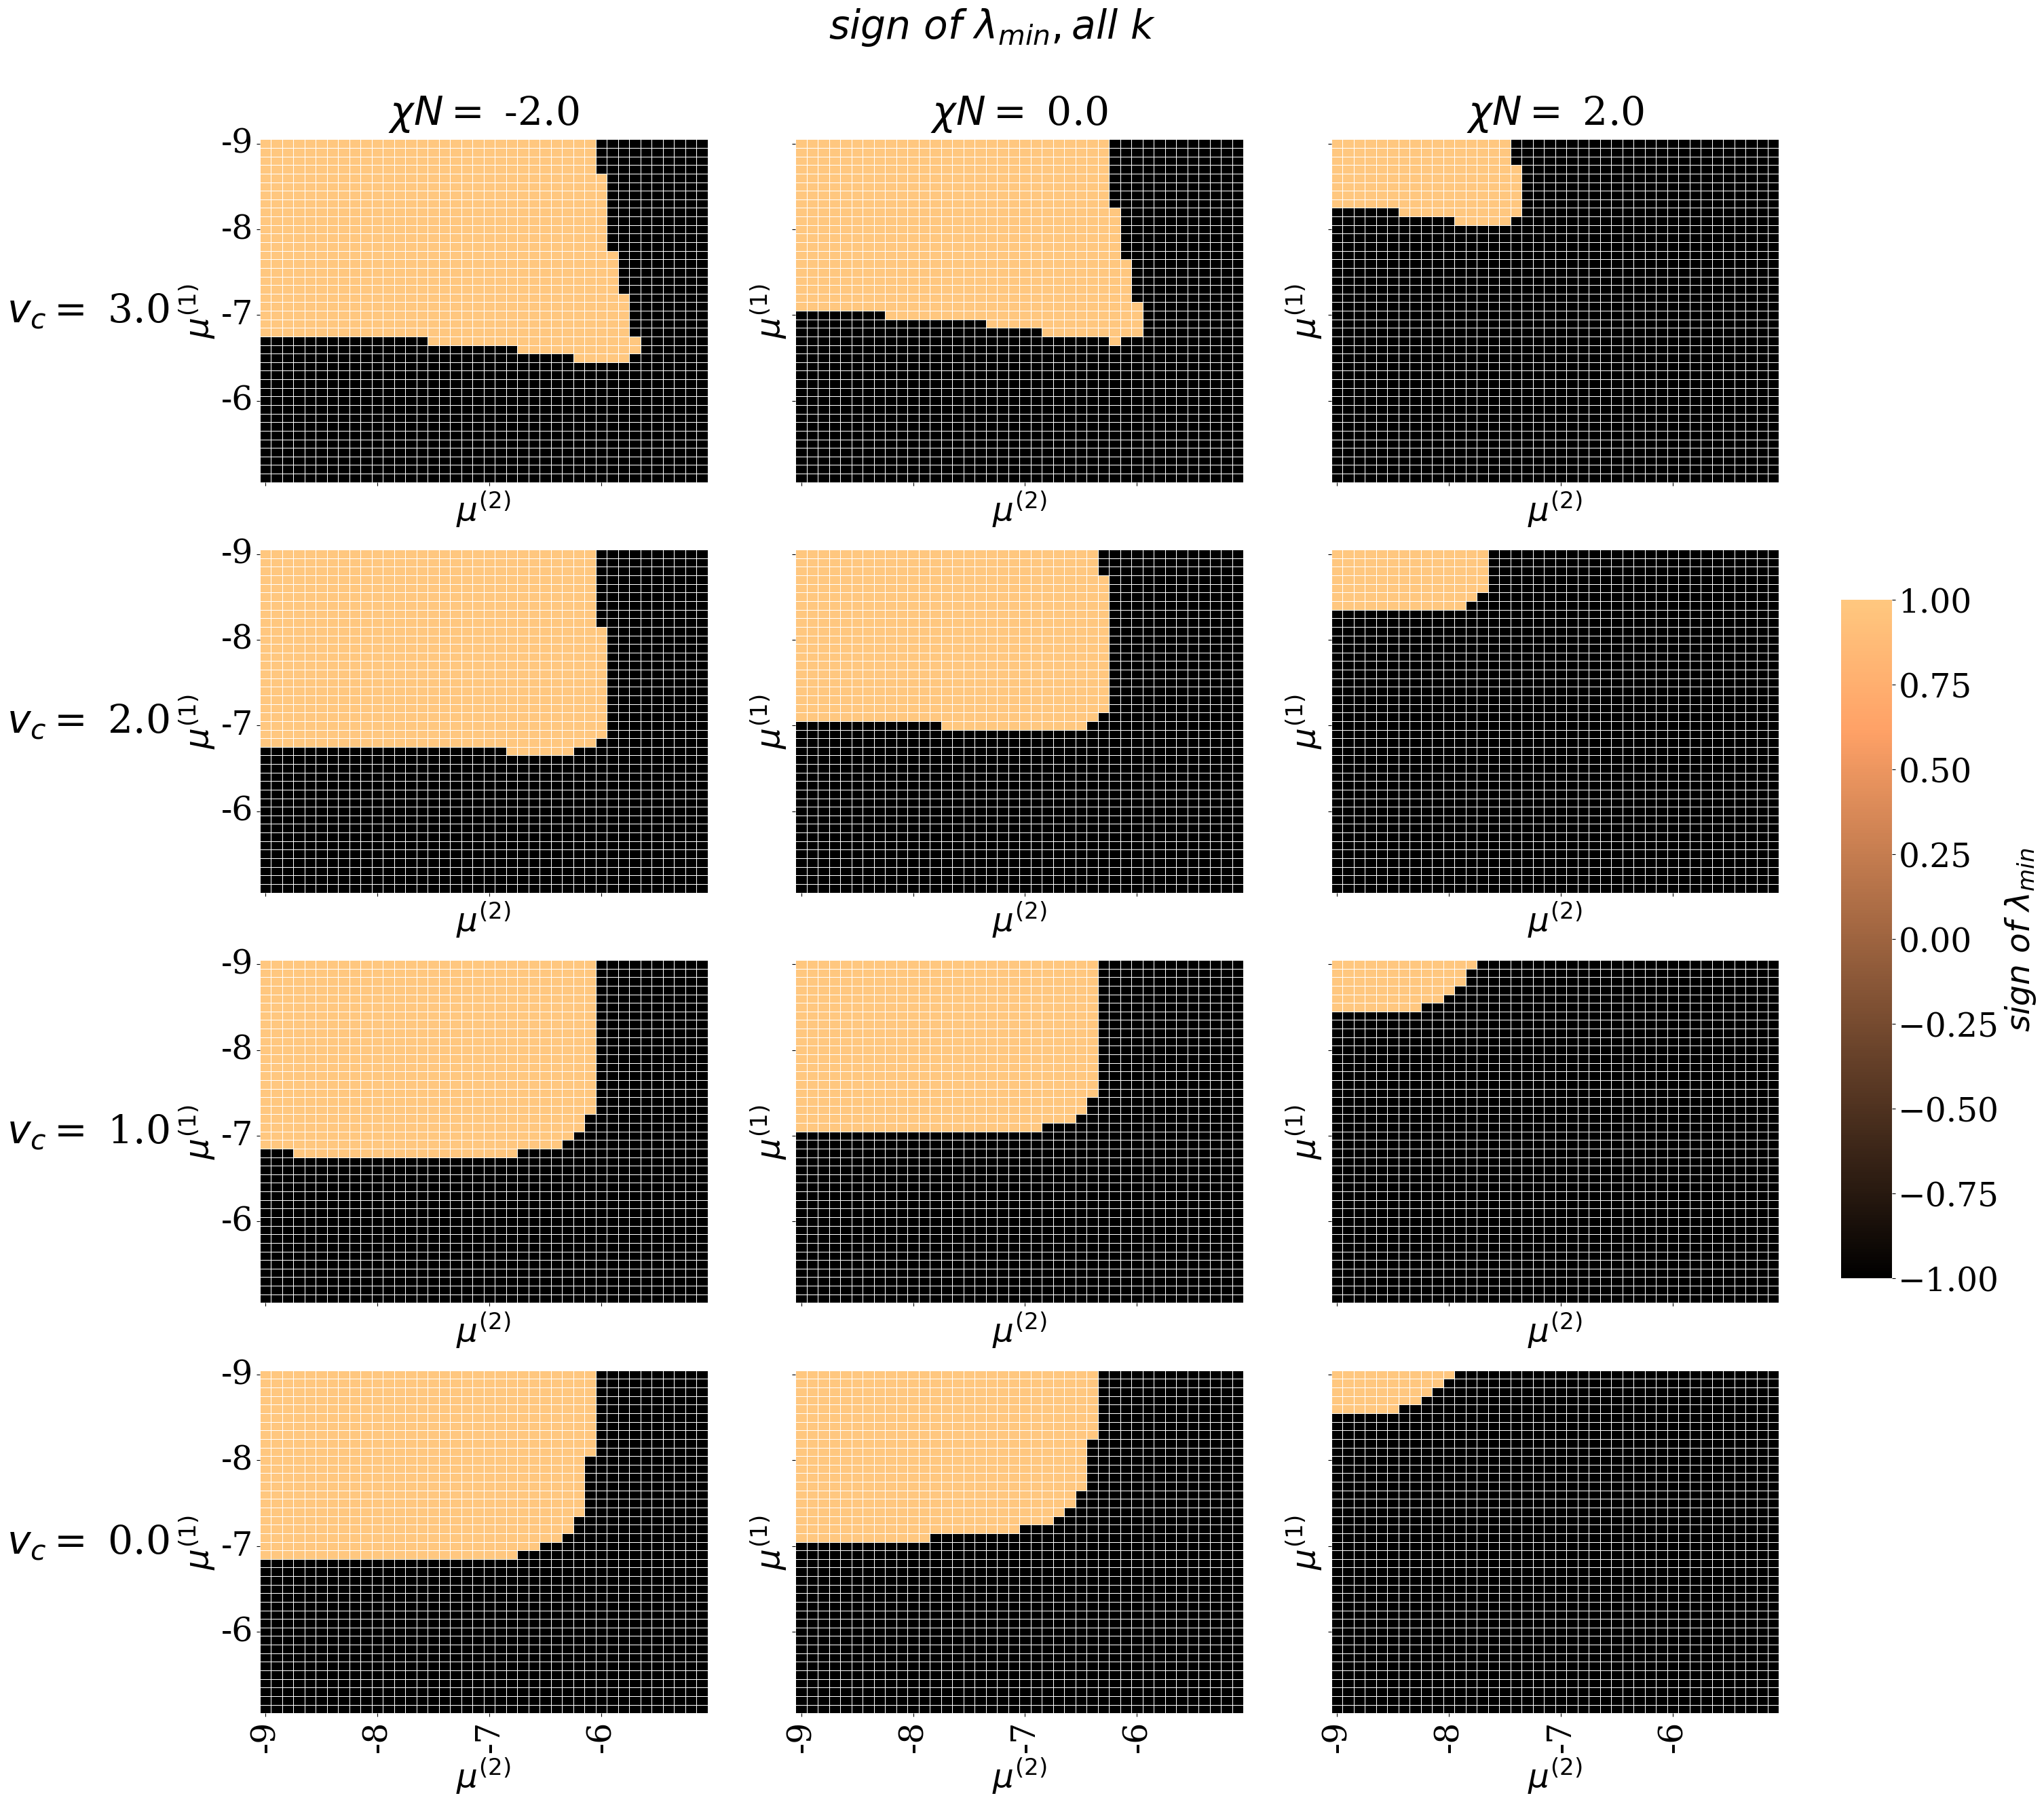

In [19]:
# fig, axs = plt.subplots(len(ID_array), 1, figsize=(5*2,17*2), sharex=True, sharey = True)
fig, axs = plt.subplots(len(ID_list), len(chi_list), figsize=(25,25), sharex=True, sharey = True)
# fig, axs = plt.subplots(3,2, figsize=(15, 18), sharex=True, sharey = True)


fig.tight_layout()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 35}
plt.rc('font', **font)
fig.suptitle(r"$ sign \ of \ \lambda_{min}, all \ k$", y = 1.05)#\
#              +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]), y = 1.03)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .3, .03, .4])

v_c_list = np.zeros(len(ID_list))
for i in range(len(ID_list)):
    ID = ID_array[i]
    #load settings
    settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

    [chrom, [klog_min, klog_max, klog_num]] = settings

    [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    
    v_c_list[i] = v_int[0][1]
    mu1_array = np.arange(mu_min, mu_max, del_mu)
    mu2_array = np.arange(mu_min, mu_max, del_mu)

    k_vec = np.logspace(klog_min, klog_max, klog_num) / b
    
    for j in range(len(chi_list)):
        ax = axs[i][j]
        chi = chi_list[j]
        #do subplot
        sns.heatmap(np.sign(spins[i][j]), linewidth=0.5, cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array,\
                    cbar=i == 0,\
                    vmin=-1, vmax=1,\
                    cbar_ax=None if i else cbar_ax, cbar_kws={'label':  r"$ sign \ of \ \lambda_{min}$"}, ax = axs[i][j])

#         ax.set_xticks(ax.get_xticks()[::2])
#         ax.set_xticklabels(mu2_array[::2].astype(np.int64))  
#         ax.set_yticks(ax.get_yticks()[::2])
#         ax.set_yticklabels(mu1_array[::2].astype(np.int64))    
        
        ax.set_xticks(ax.get_xticks()[::10])
        ax.set_xticklabels(mu2_array[::10].astype(np.int64))  
        ax.set_yticks(ax.get_yticks()[::10])
        ax.set_yticklabels(mu1_array[::10].astype(np.int64)) 
#         ax.set_xticks(ax.get_xticks()[::5])
#         ax.set_xticklabels(np.round(mu2_array[::5], 0))  
#         ax.set_yticks(ax.get_yticks()[::5])
#         ax.set_yticklabels(np.round(mu1_array[::5], 0))    

#         ax.set_title("$\chi N = $" + str(np.round(chi*N, 2)) +  ", $v_{int} = $ [" + str(v_int[0][1]) + "]\n")


cols = ["$\chi N = $ {}".format(np.round(chi*N, 2)) for chi in chi_list]
rows = ['$v_c = $ {}'.format(v_cross) for v_cross in v_c_list]

plt.setp(axs.flat, xlabel="$\mu^{(2)}$", ylabel="$\mu^{(1)}$")

pad = 5 # in points

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1.03), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.show()   


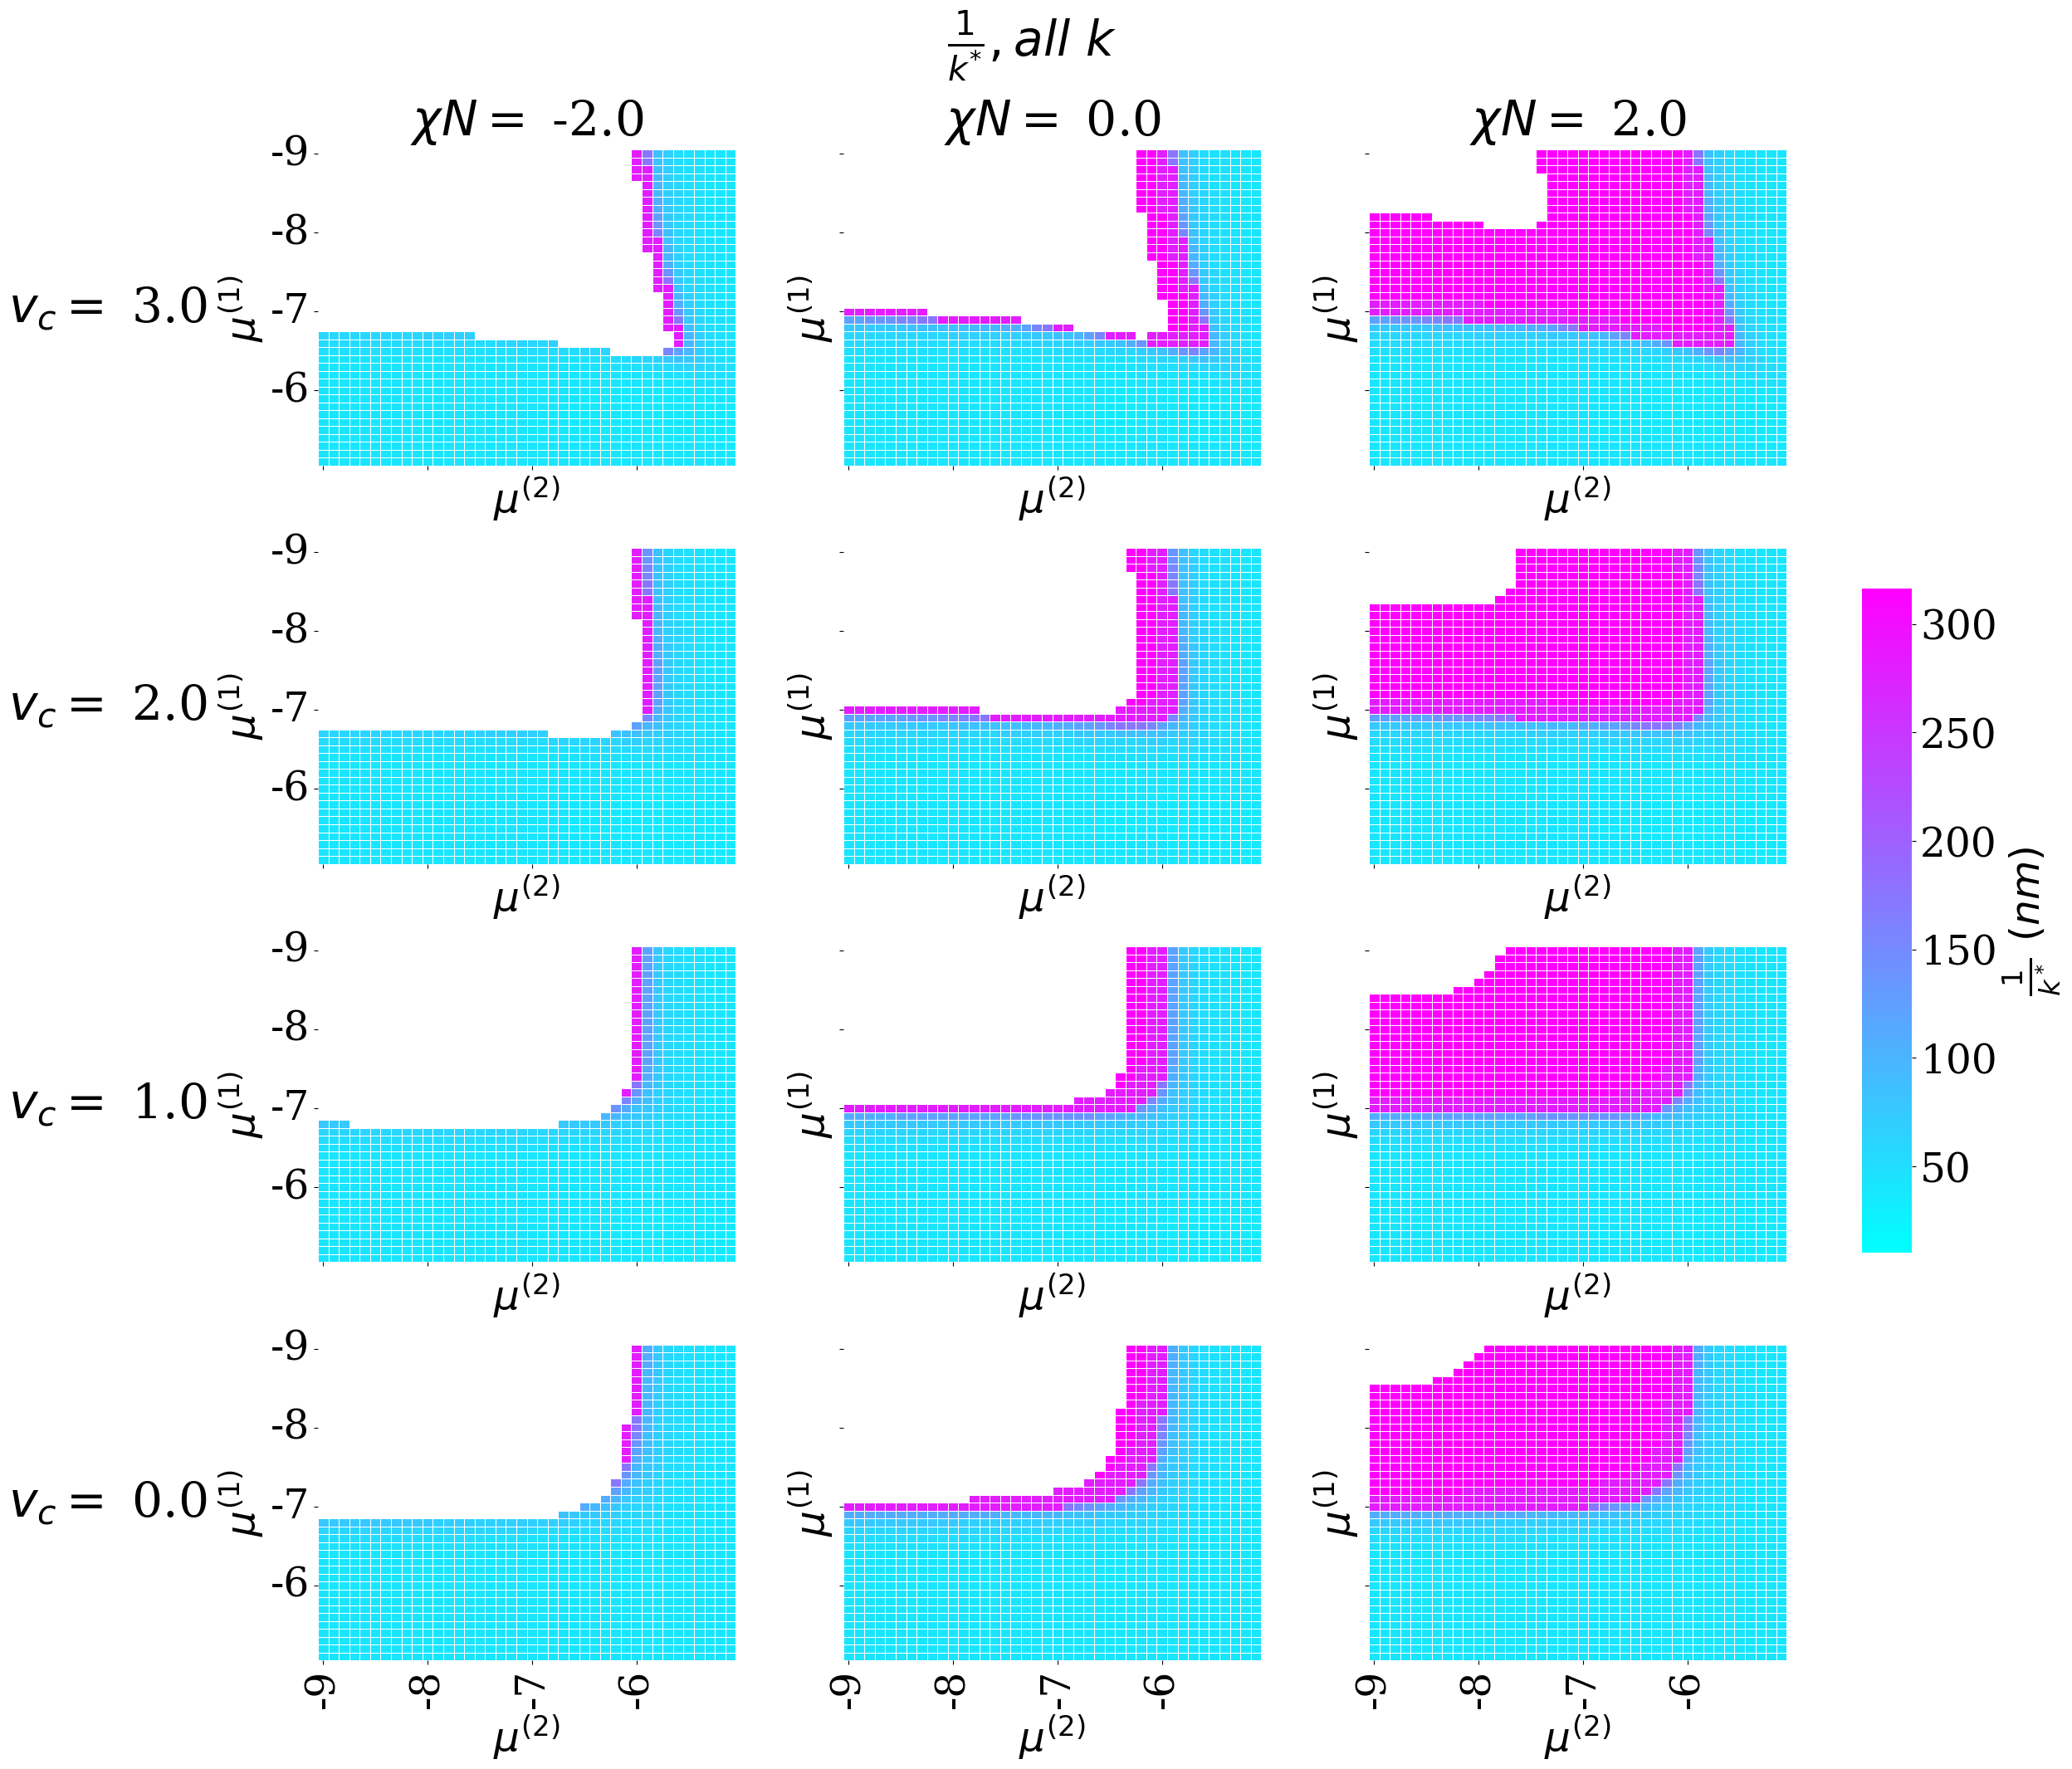

In [20]:
# fig, axs = plt.subplots(len(ID_array), 1, figsize=(5*2,17*2), sharex=True, sharey = True)
fig, axs = plt.subplots(len(ID_list), len(chi_list), figsize=(20,20), sharex=True, sharey = True)
# fig, axs = plt.subplots(3,2, figsize=(15, 18), sharex=True, sharey = True)


fig.tight_layout()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 35}
plt.rc('font', **font)
fig.suptitle(r"$ \frac{1}{k^{*}}, all \ k$" , y = 1.05)#\
#              +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]), y = 1.03)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .3, .03, .4])

v_c_list = np.zeros(len(ID_list))
for i in range(len(ID_list)):
    ID = ID_array[i]
    #load settings
    settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

    [chrom, [klog_min, klog_max, klog_num]] = settings

    [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    
    v_c_list[i] = v_int[0][1]
    mu1_array = np.arange(mu_min, mu_max, del_mu)
    mu2_array = np.arange(mu_min, mu_max, del_mu)

    k_vec = np.logspace(klog_min, klog_max, klog_num) / b
    
    for j in range(len(chi_list)):
        ax = axs[i][j]
        chi = chi_list[j]
        #do subplot 1/(k_star_arr*b)
        sns.heatmap(1/(k_stars[i][j]*b), linewidth=0.5, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array,\
                    cbar=i == 0,\
                    vmin=1/(k_vec[-1]*b), vmax=1/(k_vec[0]*b),\
                    cbar_ax=None if i else cbar_ax, cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"}, ax = axs[i][j])

#         ax.set_xticks(ax.get_xticks()[::2])
#         ax.set_xticklabels(mu2_array[::2].astype(np.int64))  
#         ax.set_yticks(ax.get_yticks()[::2])
#         ax.set_yticklabels(mu1_array[::2].astype(np.int64)) 

        ax.set_xticks(ax.get_xticks()[::10])
        ax.set_xticklabels(mu2_array[::10].astype(np.int64))  
        ax.set_yticks(ax.get_yticks()[::10])
        ax.set_yticklabels(mu1_array[::10].astype(np.int64)) 
#         ax.set_xticks(ax.get_xticks()[::2])
#         ax.set_xticklabels(np.round(mu2_array[::2], 1))  
#         ax.set_yticks(ax.get_yticks()[::2])
#         ax.set_yticklabels(np.round(mu1_array[::2],1)) 
    #     ax.set_ylabel("$\mu^{(1)}$")
    #     ax.set_xlabel("$\mu^{(2)}$")

#         ax.set_title("$\chi N = $" + str(np.round(chi*N, 2)) +  ", $v_{int} = $ [" + str(v_int[0][1]) + "]\n")


cols = ["$\chi N = $ {}".format(np.round(chi*N, 2)) for chi in chi_list]
rows = ['$v_c = $ {}'.format(v_cross) for v_cross in v_c_list]

plt.setp(axs.flat, xlabel="$\mu^{(2)}$", ylabel="$\mu^{(1)}$")

pad = 5 # in points

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1.03), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.show()   


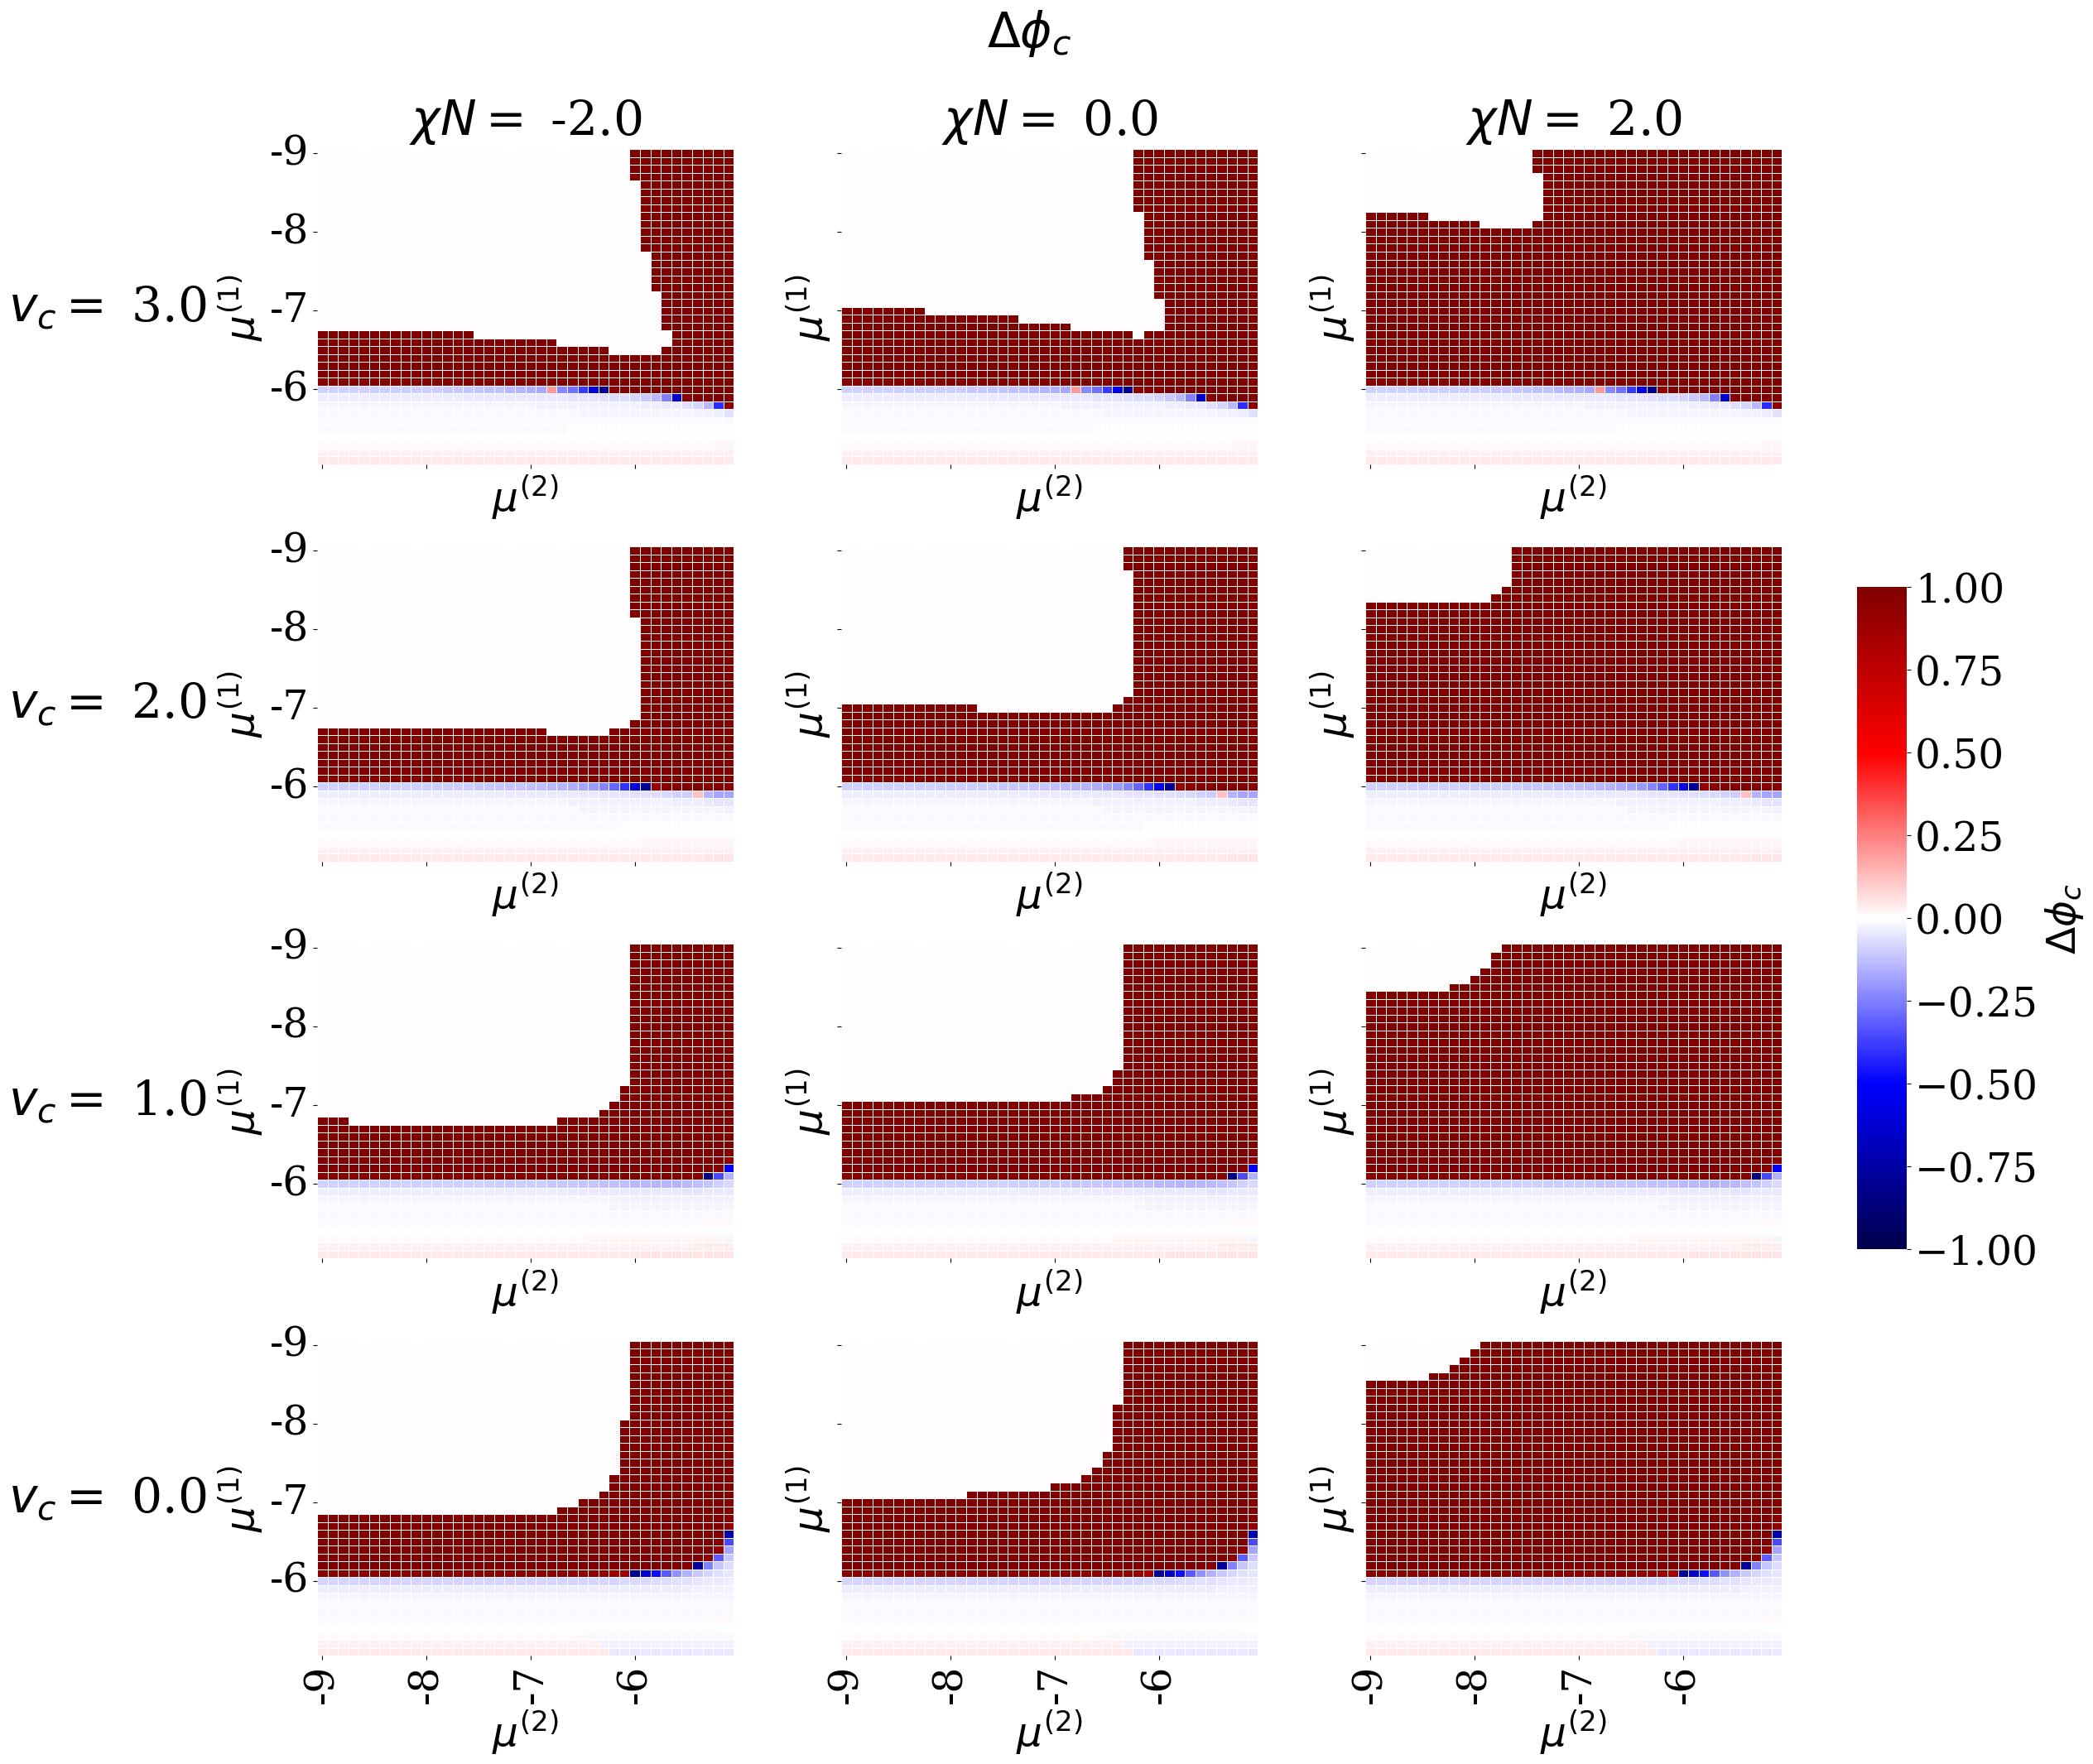

In [21]:
# fig, axs = plt.subplots(len(ID_array), 1, figsize=(5*2,17*2), sharex=True, sharey = True)
fig, axs = plt.subplots(len(ID_list), len(chi_list), figsize=(20,20), sharex=True, sharey = True)
# fig, axs = plt.subplots(3,2, figsize=(15, 18), sharex=True, sharey = True)


fig.tight_layout()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 35}
plt.rc('font', **font)
fig.suptitle(r"$ \Delta \phi_c$" , y = 1.05)#\
#              +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]), y = 1.03)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .3, .03, .4])

v_c_list = np.zeros(len(ID_list))
for i in range(len(ID_list)):
    ID = ID_array[i]
    #load settings
    settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

    [chrom, [klog_min, klog_max, klog_num]] = settings

    [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    
    v_c_list[i] = v_int[0][1]
    mu1_array = np.arange(mu_min, mu_max, del_mu)
    mu2_array = np.arange(mu_min, mu_max, del_mu)

    k_vec = np.logspace(klog_min, klog_max, klog_num) / b
    
    for j in range(len(chi_list)):
        ax = axs[i][j]
        chi = chi_list[j]
        #do subplot 1/(k_star_arr*b)
        sns.heatmap(poly_flucs[i][j], linewidth=0.5, cmap = "seismic", xticklabels=mu2_array, yticklabels=mu1_array,\
                    cbar=i == 0,\
                    vmin=-1, vmax=1,\
                    cbar_ax=None if i else cbar_ax, cbar_kws={'label':  r"$ \Delta \phi_c $"}, ax = axs[i][j])

#         ax.set_xticks(ax.get_xticks()[::2])
#         ax.set_xticklabels(mu2_array[::2].astype(np.int64))  
#         ax.set_yticks(ax.get_yticks()[::2])
#         ax.set_yticklabels(mu1_array[::2].astype(np.int64))    
        ax.set_xticks(ax.get_xticks()[::10])
        ax.set_xticklabels(mu2_array[::10].astype(np.int64))  
        ax.set_yticks(ax.get_yticks()[::10])
        ax.set_yticklabels(mu1_array[::10].astype(np.int64)) 
    #     ax.set_ylabel("$\mu^{(1)}$")
    #     ax.set_xlabel("$\mu^{(2)}$")

#         ax.set_title("$\chi N = $" + str(np.round(chi*N, 2)) +  ", $v_{int} = $ [" + str(v_int[0][1]) + "]\n")


cols = ["$\chi N = $ {}".format(np.round(chi*N, 2)) for chi in chi_list]
rows = ['$v_c = $ {}'.format(v_cross) for v_cross in v_c_list]

plt.setp(axs.flat, xlabel="$\mu^{(2)}$", ylabel="$\mu^{(1)}$")

pad = 5 # in points

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1.03), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.show()   


In [58]:
# # fig, axs = plt.subplots(len(ID_array), 1, figsize=(5*2,17*2), sharex=True, sharey = True)
# fig, axs = plt.subplots(len(ID_list), len(chi_list), figsize=(20,20), sharex=True, sharey = True)
# # fig, axs = plt.subplots(3,2, figsize=(15, 18), sharex=True, sharey = True)


# fig.tight_layout()
# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 35}
# plt.rc('font', **font)
# fig.suptitle(r"$ \Delta \phi_{\gamma_1}$" , y = 1.05)#\
# #              +  ", $e_B^{(1)} = $" + \
# #           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]), y = 1.03)
# # cbar_ax = fig.add_axes([.91, .3, .03, .4])
# cbar_ax = fig.add_axes([1, .3, .03, .4])

# v_c_list = np.zeros(len(ID_list))
# for i in range(len(ID_list)):
#     ID = ID_array[i]
#     #load settings
#     settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

#     [chrom, [klog_min, klog_max, klog_num]] = settings

#     [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    
#     v_c_list[i] = v_int[0][1]
#     mu1_array = np.arange(mu_min, mu_max, del_mu)
#     mu2_array = np.arange(mu_min, mu_max, del_mu)

#     k_vec = np.logspace(klog_min, klog_max, klog_num) / b
    
#     for j in range(len(chi_list)):
#         ax = axs[i][j]
#         chi = chi_list[j]
#         #do subplot 1/(k_star_arr*b)
#         sns.heatmap(prot1_flucs[i][j], linewidth=0.5, cmap = "seismic", xticklabels=mu2_array, yticklabels=mu1_array,\
#                     cbar=i == 0,\
#                     vmin=-1, vmax=1,\
#                     cbar_ax=None if i else cbar_ax, cbar_kws={'label':  r"$ \Delta \phi_{\gamma_1} $"}, ax = axs[i][j])

# #         ax.set_xticks(ax.get_xticks()[::2])
# #         ax.set_xticklabels(mu2_array[::2].astype(np.int64))  
# #         ax.set_yticks(ax.get_yticks()[::2])
# #         ax.set_yticklabels(mu1_array[::2].astype(np.int64)) 

#         ax.set_xticks(ax.get_xticks()[::5])
#         ax.set_xticklabels(mu2_array[::5].astype(np.int64))  
#         ax.set_yticks(ax.get_yticks()[::5])
#         ax.set_yticklabels(mu1_array[::5].astype(np.int64)) 
#     #     ax.set_ylabel("$\mu^{(1)}$")
#     #     ax.set_xlabel("$\mu^{(2)}$")

# #         ax.set_title("$\chi N = $" + str(np.round(chi*N, 2)) +  ", $v_{int} = $ [" + str(v_int[0][1]) + "]\n")


# cols = ["$\chi N = $ {}".format(np.round(chi*N, 2)) for chi in chi_list]
# rows = ['$v_c = $ {}'.format(v_cross) for v_cross in v_c_list]

# plt.setp(axs.flat, xlabel="$\mu^{(2)}$", ylabel="$\mu^{(1)}$")

# pad = 5 # in points

# for ax, col in zip(axs[0], cols):
#     ax.annotate(col, xy=(0.5, 1.03), xytext=(0, pad),
#                 xycoords='axes fraction', textcoords='offset points',
#                 size='large', ha='center', va='baseline')

# for ax, row in zip(axs[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')
    
# plt.show()   


In [59]:
# # fig, axs = plt.subplots(len(ID_array), 1, figsize=(5*2,17*2), sharex=True, sharey = True)
# fig, axs = plt.subplots(len(ID_list), len(chi_list), figsize=(20,20), sharex=True, sharey = True)
# # fig, axs = plt.subplots(3,2, figsize=(15, 18), sharex=True, sharey = True)


# fig.tight_layout()
# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 35}
# plt.rc('font', **font)
# fig.suptitle(r"$ \Delta \phi_{\gamma_2}$" , y = 1.05)#\
# #              +  ", $e_B^{(1)} = $" + \
# #           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]), y = 1.03)
# # cbar_ax = fig.add_axes([.91, .3, .03, .4])
# cbar_ax = fig.add_axes([1, .3, .03, .4])

# v_c_list = np.zeros(len(ID_list))
# for i in range(len(ID_list)):
#     ID = ID_array[i]
#     #load settings
#     settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

#     [chrom, [klog_min, klog_max, klog_num]] = settings

#     [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    
#     v_c_list[i] = v_int[0][1]
#     mu1_array = np.arange(mu_min, mu_max, del_mu)
#     mu2_array = np.arange(mu_min, mu_max, del_mu)

#     k_vec = np.logspace(klog_min, klog_max, klog_num) / b
    
#     for j in range(len(chi_list)):
#         ax = axs[i][j]
#         chi = chi_list[j]
#         #do subplot 1/(k_star_arr*b)
#         sns.heatmap(prot2_flucs[i][j], linewidth=0.5, cmap = "seismic", xticklabels=mu2_array, yticklabels=mu1_array,\
#                     cbar=i == 0,\
#                     vmin=-1, vmax=1,\
#                     cbar_ax=None if i else cbar_ax, cbar_kws={'label':  r"$ \Delta \phi_{\gamma_2} $"}, ax = axs[i][j])

#         ax.set_xticks(ax.get_xticks()[::2])
#         ax.set_xticklabels(mu2_array[::2].astype(np.int64))  
#         ax.set_yticks(ax.get_yticks()[::2])
#         ax.set_yticklabels(mu1_array[::2].astype(np.int64))    
#     #     ax.set_ylabel("$\mu^{(1)}$")
#     #     ax.set_xlabel("$\mu^{(2)}$")

# #         ax.set_title("$\chi N = $" + str(np.round(chi*N, 2)) +  ", $v_{int} = $ [" + str(v_int[0][1]) + "]\n")


# cols = ["$\chi N = $ {}".format(np.round(chi*N, 2)) for chi in chi_list]
# rows = ['$v_c = $ {}'.format(v_cross) for v_cross in v_c_list]

# plt.setp(axs.flat, xlabel="$\mu^{(2)}$", ylabel="$\mu^{(1)}$")

# pad = 5 # in points

# for ax, col in zip(axs[0], cols):
#     ax.annotate(col, xy=(0.5, 1.03), xytext=(0, pad),
#                 xycoords='axes fraction', textcoords='offset points',
#                 size='large', ha='center', va='baseline')

# for ax, row in zip(axs[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')
    
# plt.show()   


In [112]:
np.shape(prot2_flucs)

(4, 3)

0
0.2651342669366548
1
0.3604963157198602
2
0.3008083859410264
3
0.35092008559127236


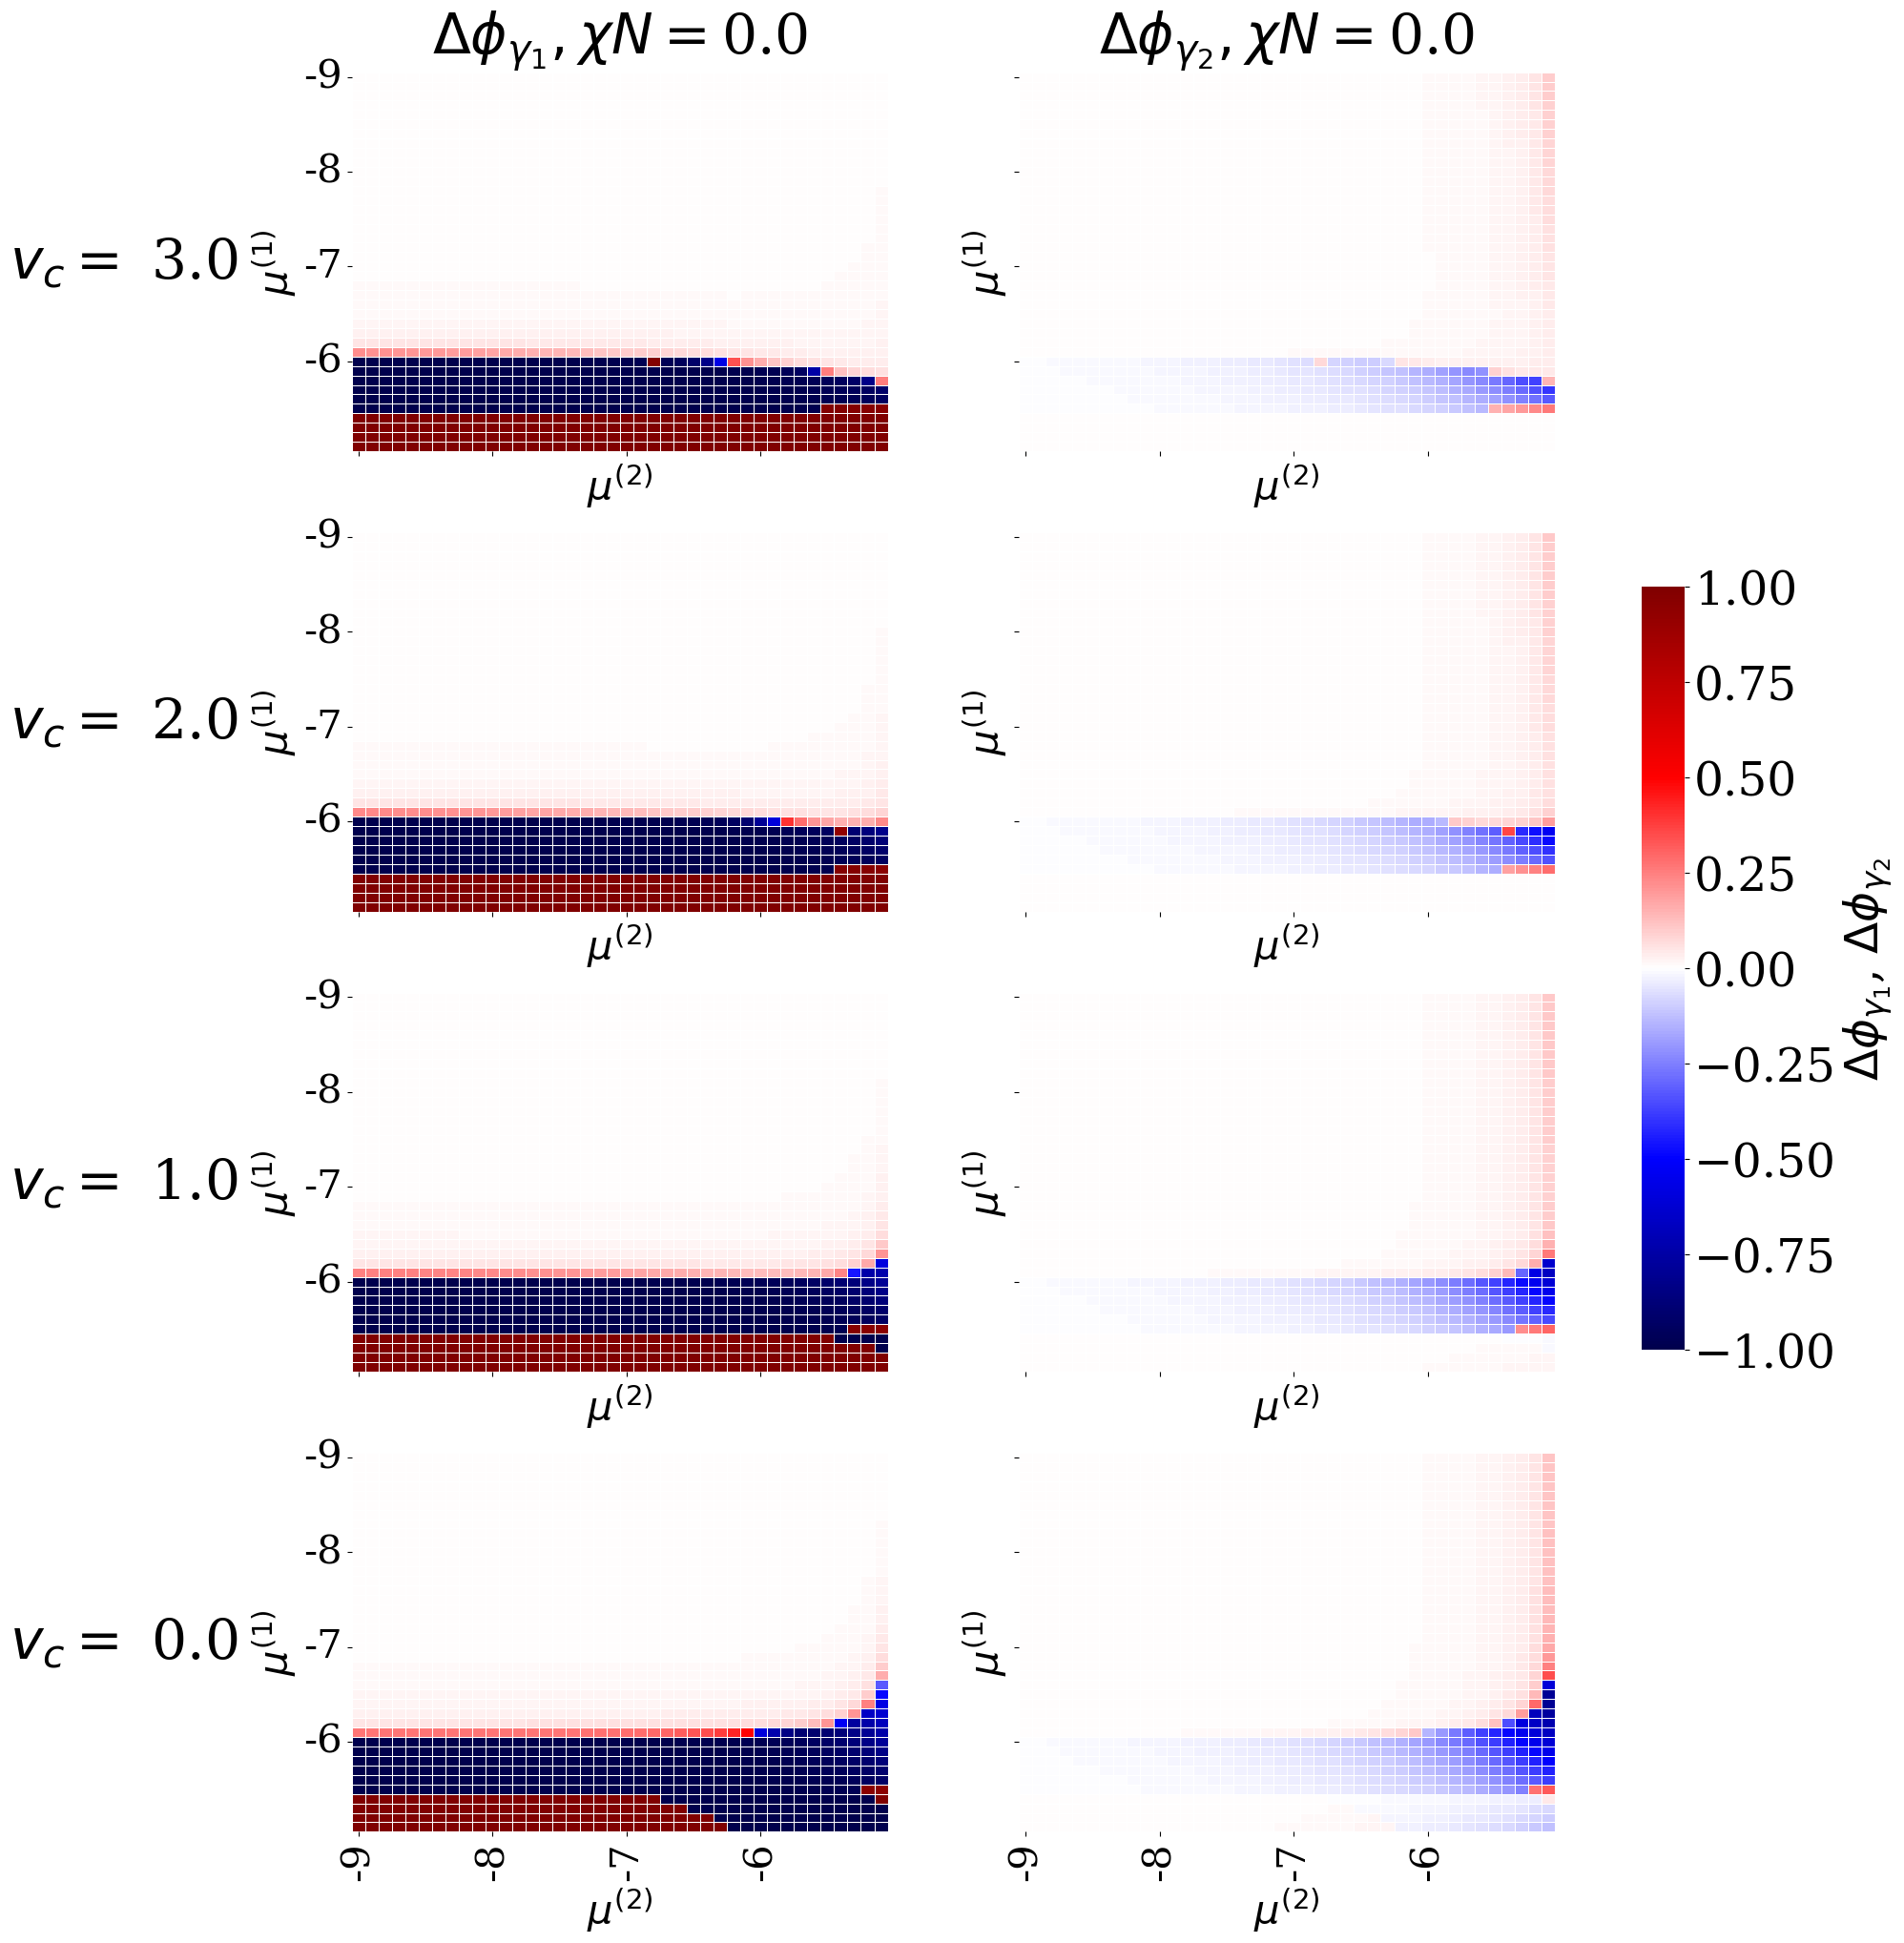

In [23]:
# fig, axs = plt.subplots(len(ID_array), 1, figsize=(5*2,17*2), sharex=True, sharey = True)
fig, axs = plt.subplots(len(ID_array), 2, figsize=(15,20), sharex=True, sharey = True)
# fig, axs = plt.subplots(3,2, figsize=(15, 18), sharex=True, sharey = True)

# fig = plt.figure()
# plt.figure(figsize=(10,8))
fig.tight_layout()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 35}
plt.rc('font', **font)
# fig.suptitle(r"$ \langle f^{(1)} \rangle $", y = 1.03)#\
#              +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]), y = 1.03)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .3, .03, .4])
# for i, ax in enumerate(axs.flat):

prot_fluc_list = [prot1_flucs, prot2_flucs]

chi_ind = 1

for i in range(len(ID_array)):
#     ax 
#     if i == 5:
#         ax.axis("off")
#         ax.grid(False)
#         ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#         break
    print(i)
    ID = ID_array[i]
    settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

    [chrom, [klog_min, klog_max, klog_num]] = settings

    [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

    mu1_array = np.arange(mu_min, mu_max, del_mu)
    mu2_array = np.arange(mu_min, mu_max, del_mu)

    k_vec = np.logspace(klog_min, klog_max, klog_num) / b
    for j in range(2):
        if j ==1:
            print(np.max(prot_fluc_list[j][i][chi_ind]))
        ax = axs[i][j]
        prot_fluc = prot_fluc_list[j]
        titl = ""
        if j == 0:
            titl = r"$ \Delta \phi_{\gamma_1} $"
        elif j == 1:
            titl = r"$ \Delta \phi_{\gamma_2} $"
        ax_titl = r"$ \Delta \phi_{\gamma_1} $, $ \Delta \phi_{\gamma_2} $"
    #     sns.heatmap(density_maps_array[i][0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'}, ax = ax)
        sns.heatmap(prot_fluc[i][chi_ind], linewidth=0.5, cmap = "seismic", xticklabels=mu2_array, yticklabels=mu1_array,\
                    cbar=i == 0,
                    vmin=-1, vmax=1,
                    cbar_ax=None if i else cbar_ax, cbar_kws={'label': ax_titl }, ax = ax)

#         ax.set_xticks(ax.get_xticks()[::2])
#         ax.set_xticklabels(mu2_array[::2].astype(np.int64))  
#         ax.set_yticks(ax.get_yticks()[::2])
#         ax.set_yticklabels(mu1_array[::2].astype(np.int64)) 
        ax.set_xticks(ax.get_xticks()[::10])
        ax.set_xticklabels(mu2_array[::10].astype(np.int64))  
        ax.set_yticks(ax.get_yticks()[::10])
        ax.set_yticklabels(mu1_array[::10].astype(np.int64)) 
#     ax.set_ylabel("$\mu^{(1)}$")
#     ax.set_xlabel("$\mu^{(2)}$")
#     ax.set_title(" $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")

# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel("$\mu^{(2)}$")
# plt.ylabel("$\mu^{(1)}$")
# # plt.xlabel("$\mu^{(2)}$")
chi_str = str(np.round(chi_list[chi_ind]*N,2))
prot_fluc_tits = [r"$ \Delta \phi_{\gamma_1} , \chi N = $" + chi_str, r"$ \Delta \phi_{\gamma_2}, \chi N = $" + chi_str]
plt.setp(axs.flat, xlabel="$\mu^{(2)}$", ylabel="$\mu^{(1)}$")
rows = ['$v_c = $ {}'.format(v_cross) for v_cross in v_c_list]

cols = [tit for tit in prot_fluc_tits]

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1.03), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.show()

0
1
2
3


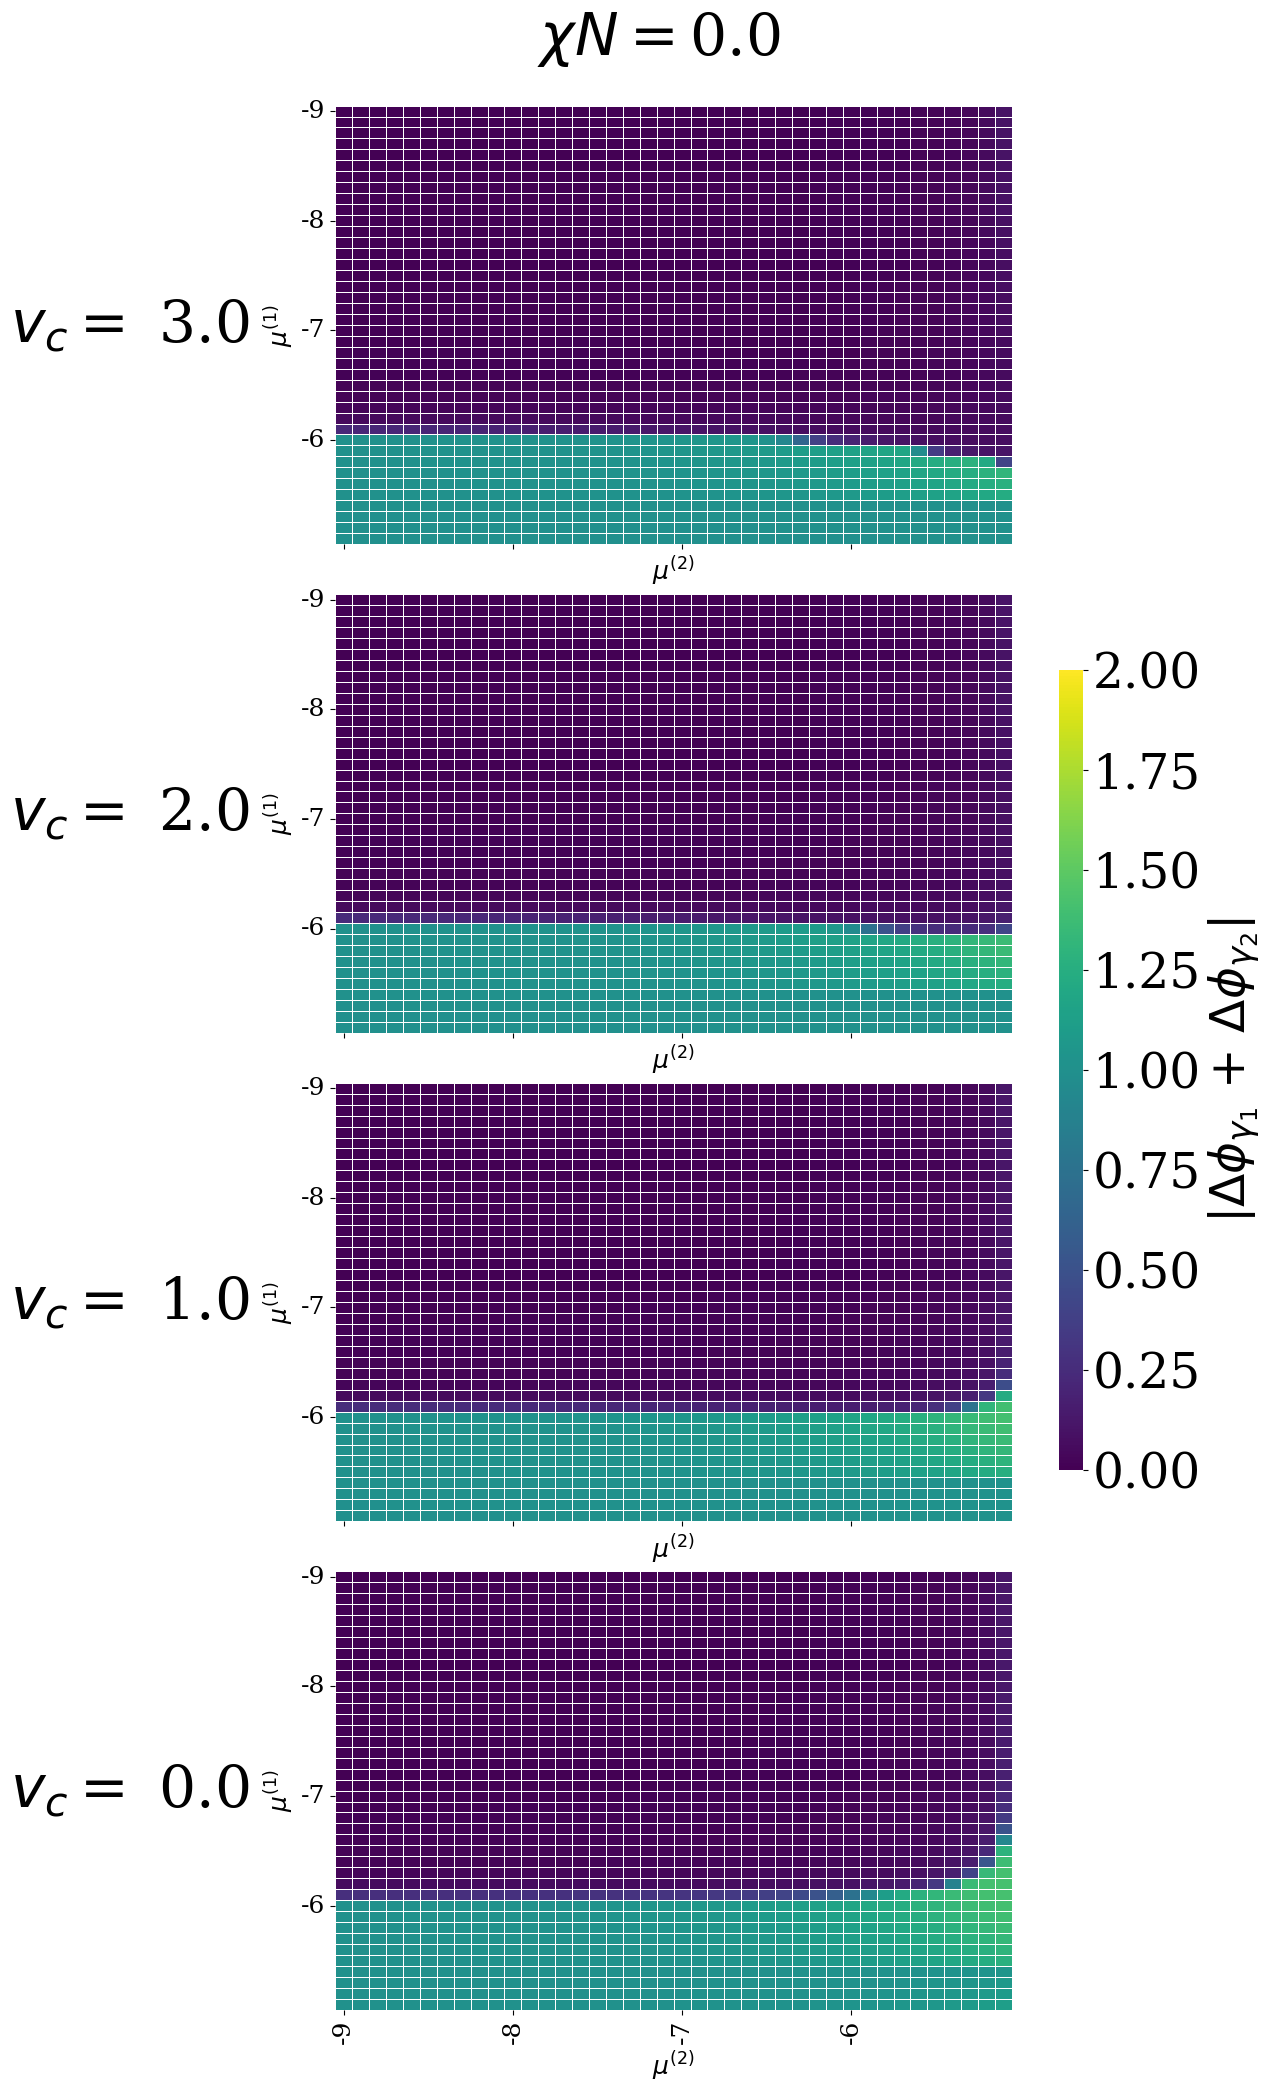

In [29]:
# fig, axs = plt.subplots(len(ID_array), 1, figsize=(5*2,17*2), sharex=True, sharey = True)
fig, axs = plt.subplots(len(ID_array), 1, figsize=(8,20), sharex=True, sharey = True)
# fig, axs = plt.subplots(3,2, figsize=(15, 18), sharex=True, sharey = True)

# fig = plt.figure()
# plt.figure(figsize=(10,8))
fig.tight_layout()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 35}
plt.rc('font', **font)
# fig.suptitle(r"$ \langle f^{(1)} \rangle $", y = 1.03)#\
#              +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]), y = 1.03)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .3, .03, .4])
# for i, ax in enumerate(axs.flat):

prot_fluc_list = [prot1_flucs, prot2_flucs]

# chi_ind = 1

chi_str = str(np.round(chi_list[chi_ind]*N,2))
fig.suptitle(r"$ \chi N =  $"+ chi_str, y = 1.03)#\

for i in range(len(ID_array)):
#     ax 
#     if i == 5:
#         ax.axis("off")
#         ax.grid(False)
#         ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#         break
    print(i)
    ID = ID_array[i]
    settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

    [chrom, [klog_min, klog_max, klog_num]] = settings

    [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

    mu1_array = np.arange(mu_min, mu_max, del_mu)
    mu2_array = np.arange(mu_min, mu_max, del_mu)

    k_vec = np.logspace(klog_min, klog_max, klog_num) / b
#     for j in range(2):
    ax = axs[i]
    prot1_fluc = prot_fluc_list[0]
    prot2_fluc = prot_fluc_list[1]
    titl = ""
    if j == 0:
        titl = r"$ \Delta \phi_{\gamma_1} $"
    elif j == 1:
        titl = r"$ \Delta \phi_{\gamma_2} $"
    ax_titl = r"$ | \Delta \phi_{\gamma_1} $ + $ \Delta \phi_{\gamma_2} |$"
#     sns.heatmap(density_maps_array[i][0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'}, ax = ax)
    sns.heatmap(np.abs(prot1_fluc[i][chi_ind] + prot2_fluc[i][chi_ind]), linewidth=0.5, cmap = "viridis", xticklabels=mu2_array, yticklabels=mu1_array,\
                cbar=i == 0,
                vmin=0, vmax=2,
                cbar_ax=None if i else cbar_ax, cbar_kws={'label': ax_titl }, ax = ax)

#     ax.set_xticks(ax.get_xticks()[::2])
#     ax.set_xticklabels(mu2_array[::2].astype(np.int64))  
#     ax.set_yticks(ax.get_yticks()[::2])
#     ax.set_yticklabels(mu1_array[::2].astype(np.int64))    
    ax.set_xticks(ax.get_xticks()[::10])
    ax.set_xticklabels(mu2_array[::10].astype(np.int64))  
    ax.set_yticks(ax.get_yticks()[::10])
    ax.set_yticklabels(mu1_array[::10].astype(np.int64)) 

# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel("$\mu^{(2)}$")
# plt.ylabel("$\mu^{(1)}$")
# # plt.xlabel("$\mu^{(2)}$")
chi_str = str(np.round(chi_list[chi_ind]*N,2))
prot_fluc_tits = [r"$ \Delta \phi_{\gamma_1} , \chi N = $" + chi_str, r"$ \Delta \phi_{\gamma_2}, \chi N = $" + chi_str]
plt.setp(axs.flat, xlabel="$\mu^{(2)}$", ylabel="$\mu^{(1)}$")
rows = ['$v_c = $ {}'.format(v_cross) for v_cross in v_c_list]

cols = [tit for tit in prot_fluc_tits]

# for ax, col in zip(axs[0], cols):
#     ax.annotate(col, xy=(0.5, 1.03), xytext=(0, pad),
#                 xycoords='axes fraction', textcoords='offset points',
#                 size='large', ha='center', va='baseline')

for ax, row in zip(axs[:], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.show()

In [25]:
prot1_max = 0
prot2_max = 0
for i in range(len(ID_array)):
    loc1_max = np.max(np.abs(prot_fluc_list[0][i][chi_ind]))
    loc2_max = np.max(np.abs(prot_fluc_list[1][i][chi_ind]))
    
    if prot1_max < loc1_max:
        prot1_max = loc1_max
    if prot2_max < loc2_max:
        prot2_max = loc2_max
        

0
1
2
3


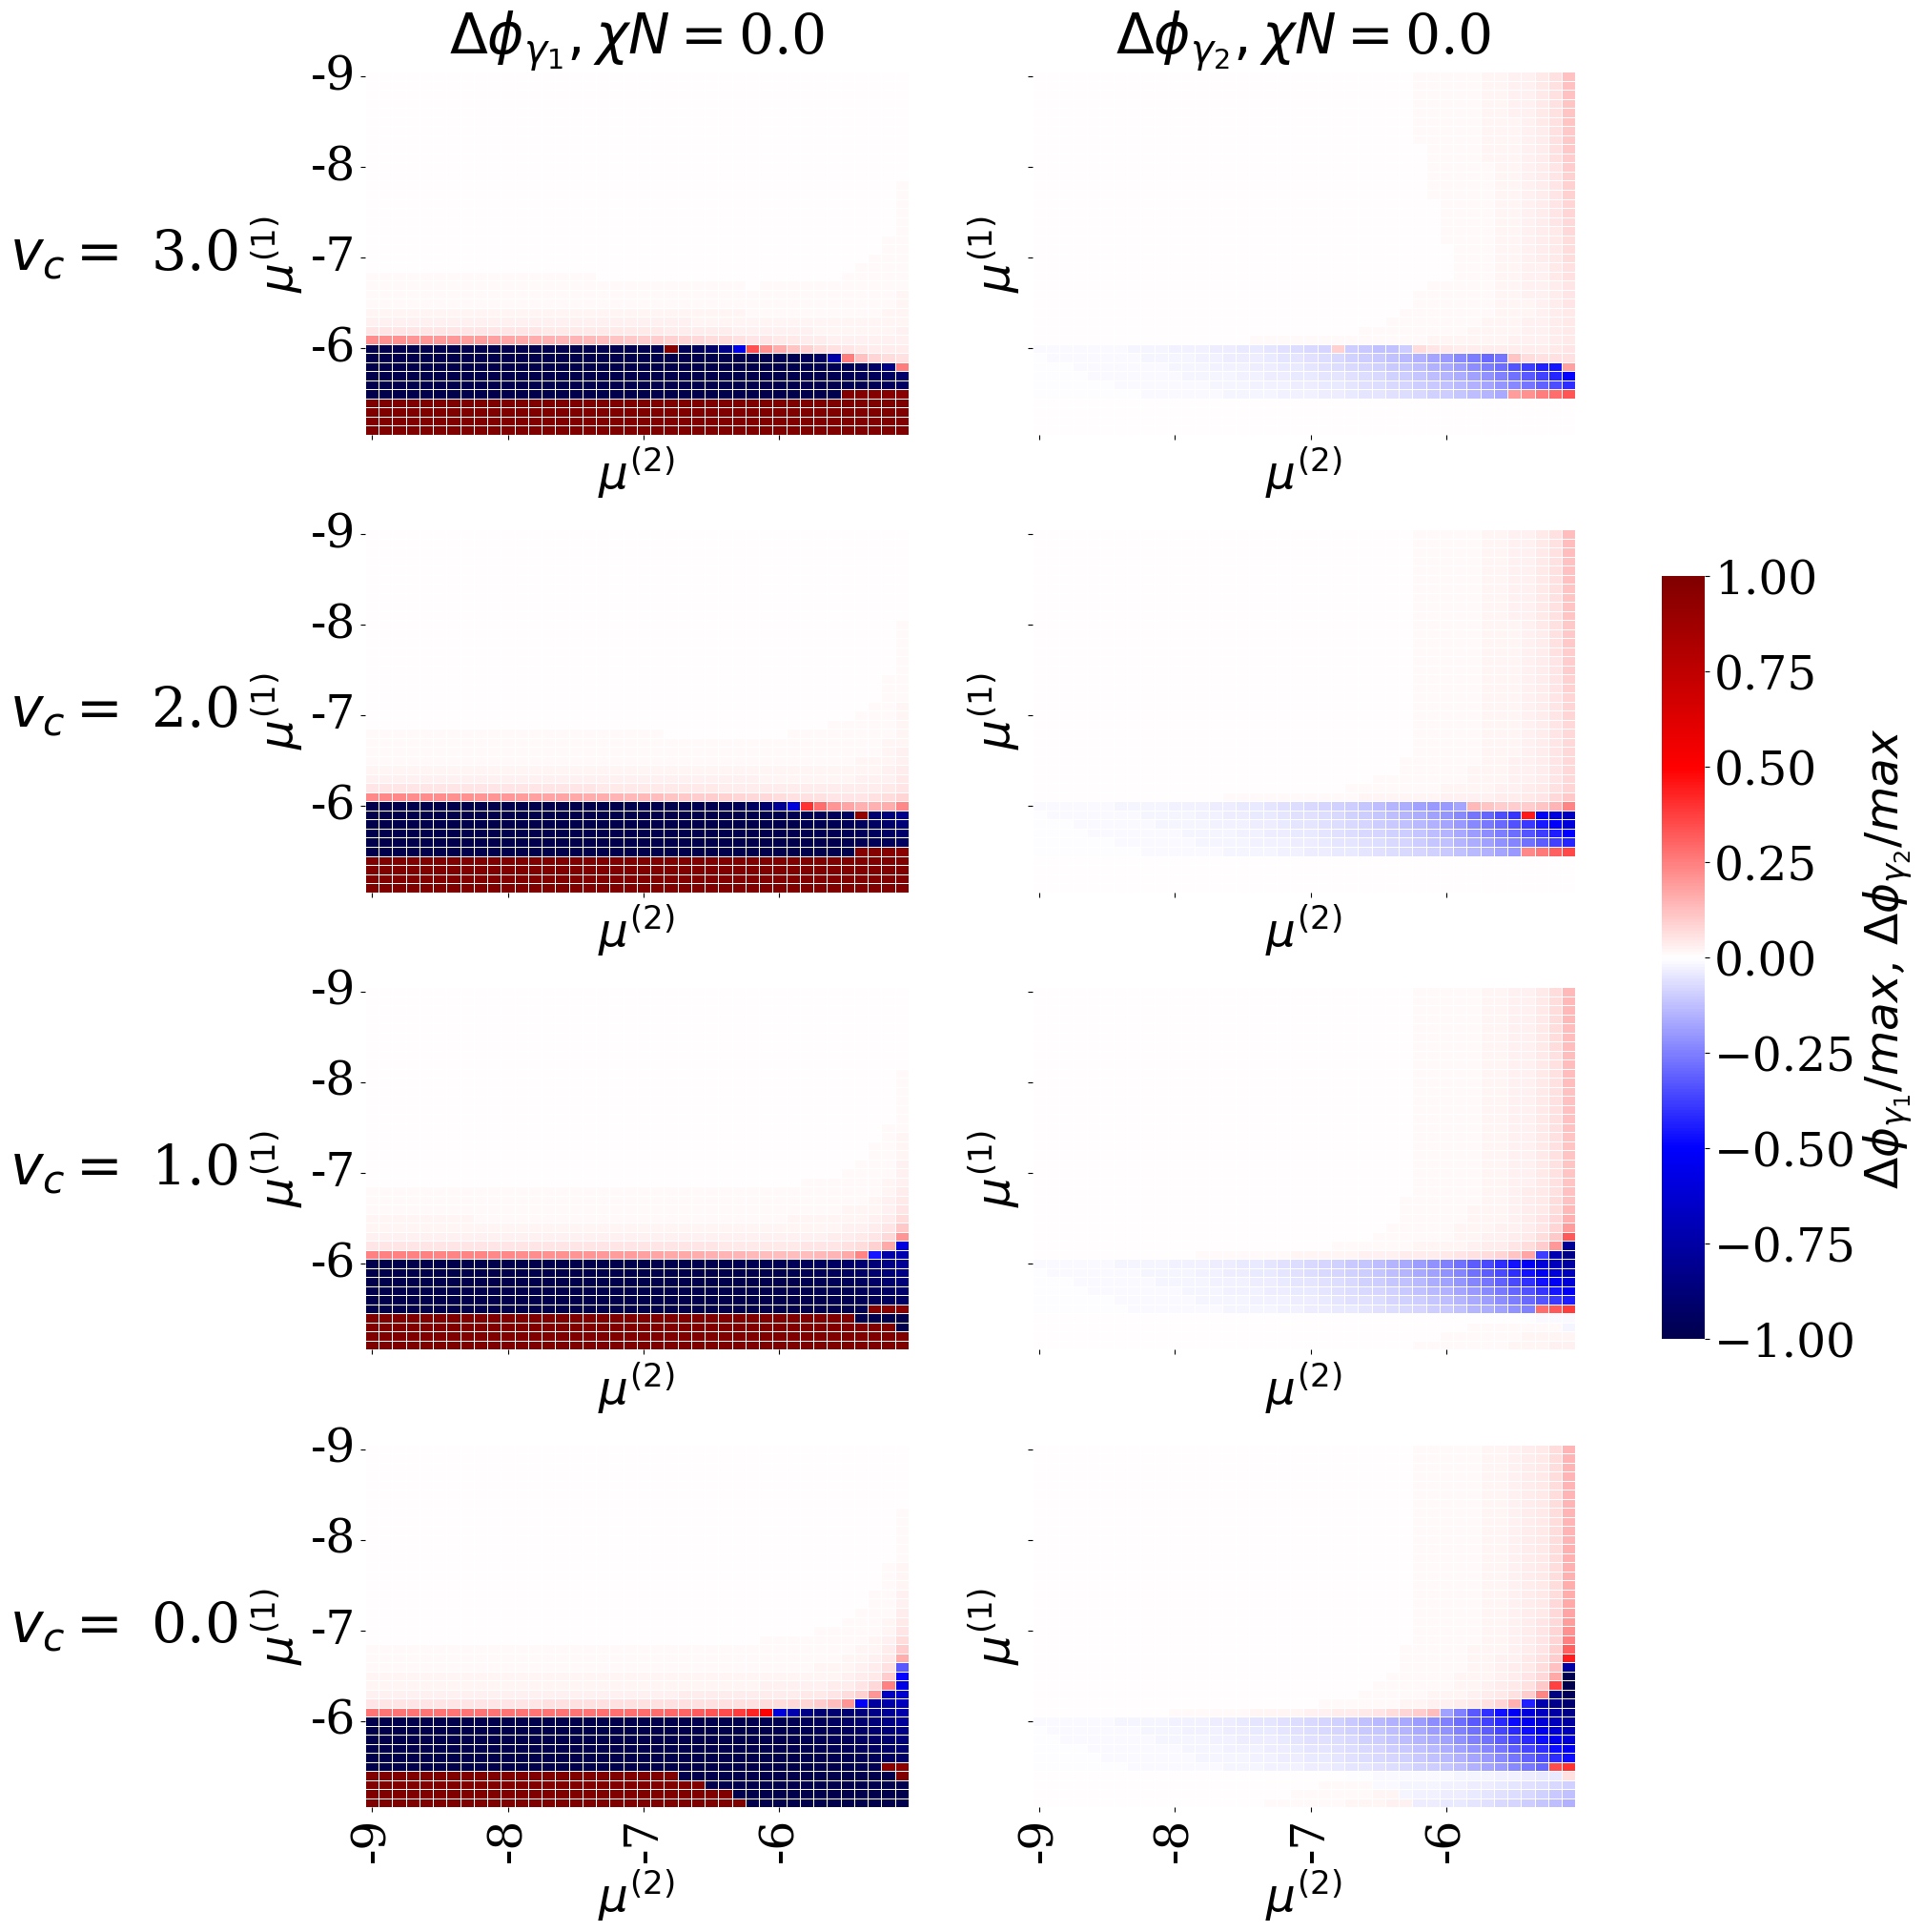

In [26]:
# fig, axs = plt.subplots(len(ID_array), 1, figsize=(5*2,17*2), sharex=True, sharey = True)
fig, axs = plt.subplots(len(ID_array), 2, figsize=(15,20), sharex=True, sharey = True)
# fig, axs = plt.subplots(3,2, figsize=(15, 18), sharex=True, sharey = True)

# fig = plt.figure()
# plt.figure(figsize=(10,8))
fig.tight_layout()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 35}
plt.rc('font', **font)
# fig.suptitle(r"$ \langle f^{(1)} \rangle $", y = 1.03)#\
#              +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]), y = 1.03)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .3, .03, .4])
# for i, ax in enumerate(axs.flat):

prot_fluc_list = [prot1_flucs, prot2_flucs]
prot_max_list = [prot1_max, prot2_max]
chi_ind = 1

for i in range(len(ID_array)):
#     ax 
#     if i == 5:
#         ax.axis("off")
#         ax.grid(False)
#         ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#         break
    print(i)
    ID = ID_array[i]
    settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

    [chrom, [klog_min, klog_max, klog_num]] = settings

    [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

    mu1_array = np.arange(mu_min, mu_max, del_mu)
    mu2_array = np.arange(mu_min, mu_max, del_mu)

    k_vec = np.logspace(klog_min, klog_max, klog_num) / b
    for j in range(2):
#         if j ==1:
#             print(np.max(prot_fluc_list[j][i][chi_ind]))
#             print(prot_max_list[j])
#             print(np.max(prot_fluc_list[j][i][chi_ind])/prot_max_list[j])
#             prot_fluc = prot_fluc_list[j]
#             print(np.max(prot_fluc[i][chi_ind]/prot_max_list[j]))

        ax = axs[i][j]
        prot_fluc = prot_fluc_list[j]
        titl = ""
        if j == 0:
            titl = r"$ \Delta \phi_{\gamma_1} $"
        elif j == 1:
            titl = r"$ \Delta \phi_{\gamma_2} $"
        ax_titl = r"$ \Delta \phi_{\gamma_1}/max $, $ \Delta \phi_{\gamma_2}/max $"
    #     sns.heatmap(density_maps_array[i][0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'}, ax = ax)
        sns.heatmap(prot_fluc[i][chi_ind]/prot_max_list[j], linewidth=0.5, cmap = "seismic", xticklabels=mu2_array, yticklabels=mu1_array,\
                    cbar=i == 0,
                    vmin=-1, vmax=1,
                    cbar_ax=None if i else cbar_ax, cbar_kws={'label': ax_titl }, ax = ax)
#         if j==1 and i == 0:
#             print(prot_fluc[i][chi_ind]/prot_max_list[j])
#         ax.set_xticks(ax.get_xticks()[::2])
#         ax.set_xticklabels(mu2_array[::2].astype(np.int64))  
#         ax.set_yticks(ax.get_yticks()[::2])
#         ax.set_yticklabels(mu1_array[::2].astype(np.int64)) 
        ax.set_xticks(ax.get_xticks()[::10])
        ax.set_xticklabels(mu2_array[::10].astype(np.int64))  
        ax.set_yticks(ax.get_yticks()[::10])
        ax.set_yticklabels(mu1_array[::10].astype(np.int64)) 
#     ax.set_ylabel("$\mu^{(1)}$")
#     ax.set_xlabel("$\mu^{(2)}$")
#     ax.set_title(" $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")

# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel("$\mu^{(2)}$")
# plt.ylabel("$\mu^{(1)}$")
# # plt.xlabel("$\mu^{(2)}$")
chi_str = str(np.round(chi_list[chi_ind]*N,2))
prot_fluc_tits = [r"$ \Delta \phi_{\gamma_1} , \chi N = $" + chi_str, r"$ \Delta \phi_{\gamma_2}, \chi N = $" + chi_str]
plt.setp(axs.flat, xlabel="$\mu^{(2)}$", ylabel="$\mu^{(1)}$")
rows = ['$v_c = $ {}'.format(v_cross) for v_cross in v_c_list]

cols = [tit for tit in prot_fluc_tits]

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1.03), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.show()

0
1
2
3


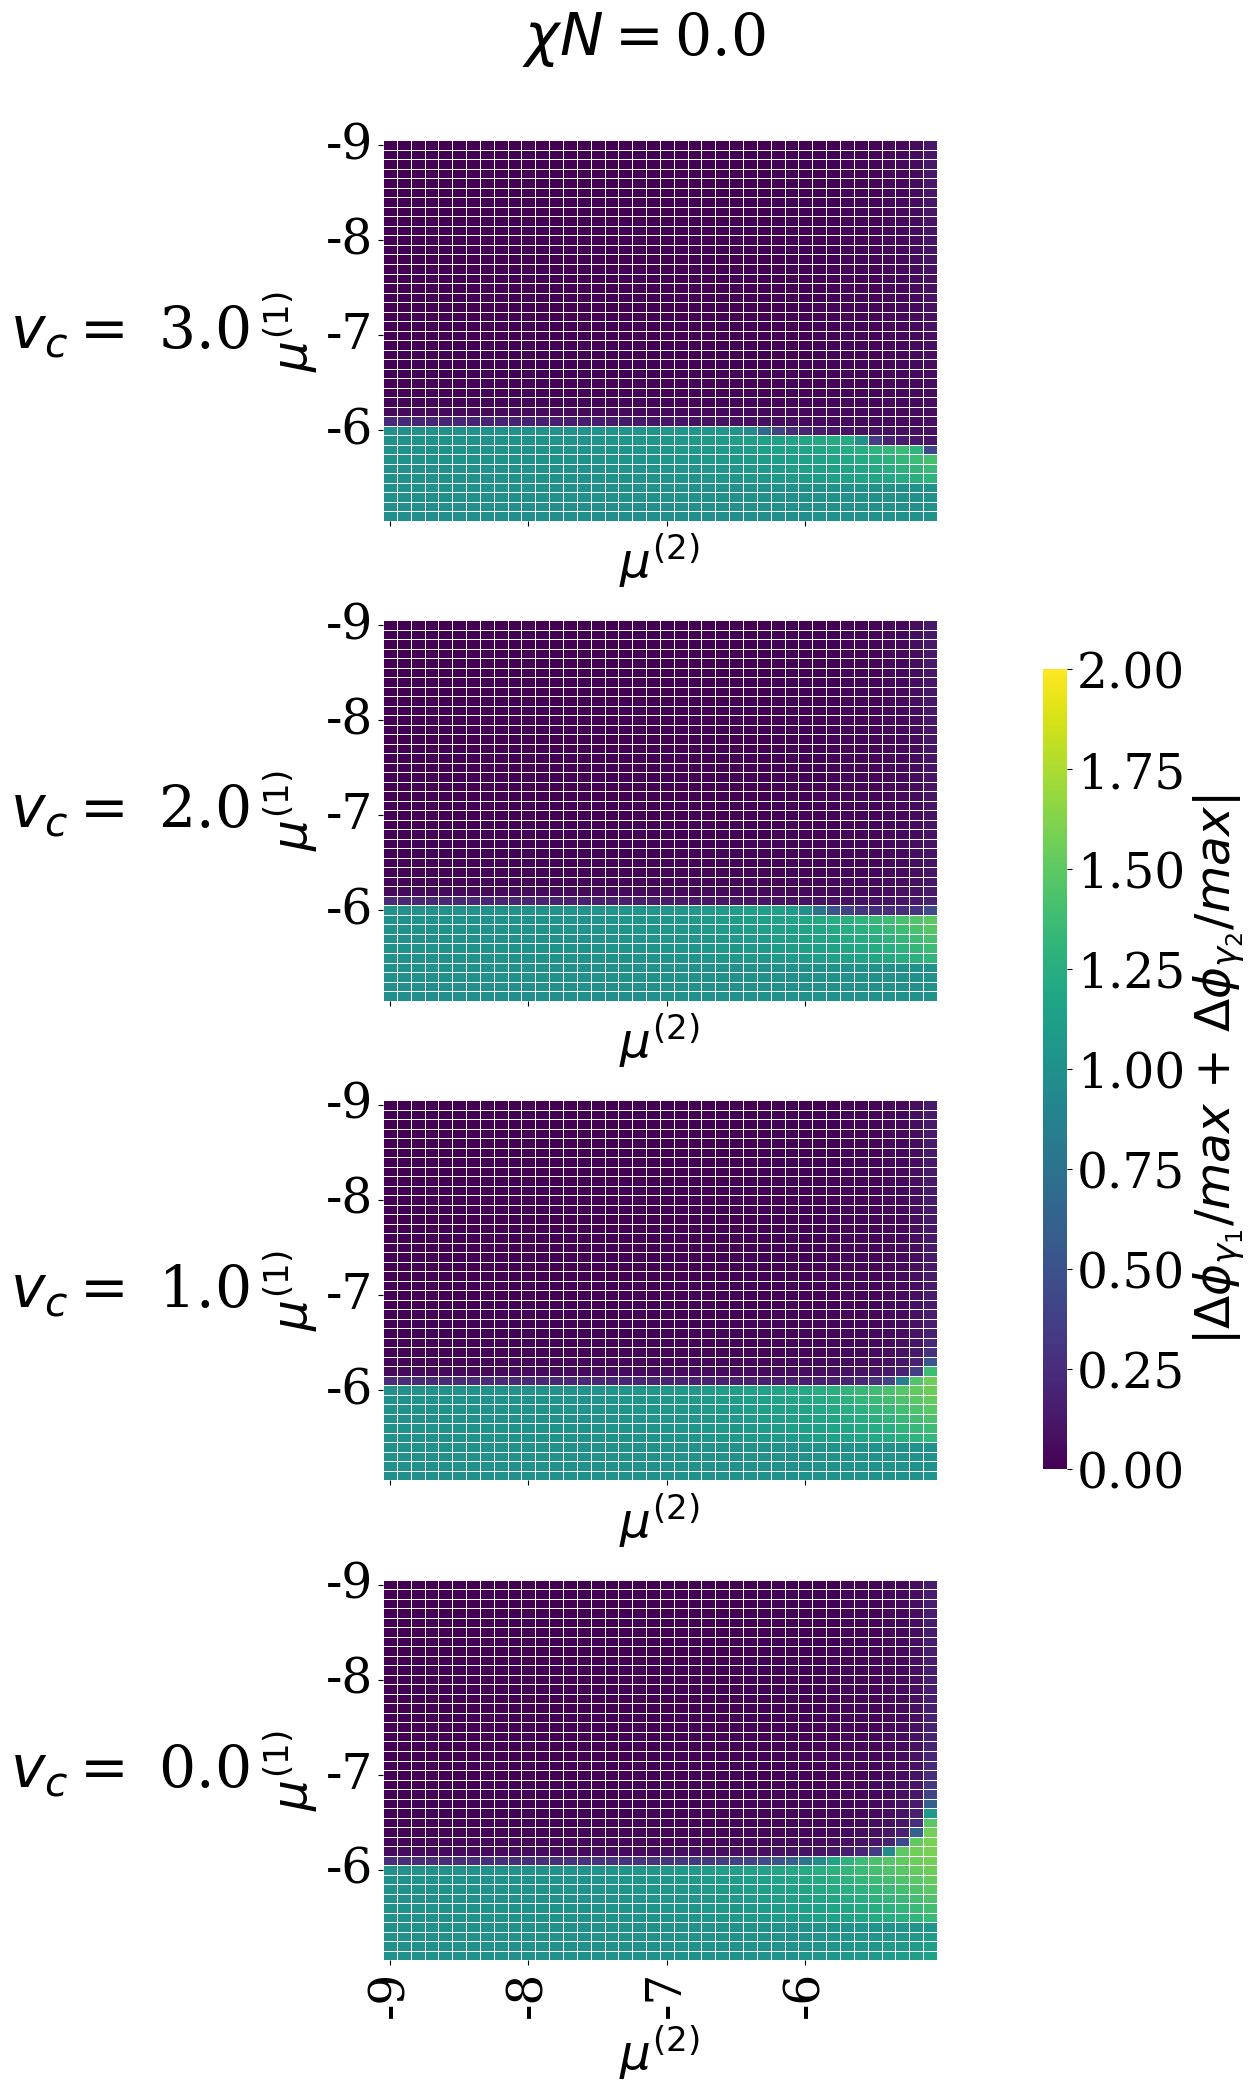

In [27]:

# fig, axs = plt.subplots(len(ID_array), 1, figsize=(5*2,17*2), sharex=True, sharey = True)
fig, axs = plt.subplots(len(ID_array), 1, figsize=(8,20), sharex=True, sharey = True)
# fig, axs = plt.subplots(3,2, figsize=(15, 18), sharex=True, sharey = True)

# fig = plt.figure()
# plt.figure(figsize=(10,8))
fig.tight_layout()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 35}
plt.rc('font', **font)
# fig.suptitle(r"$ \langle f^{(1)} \rangle $", y = 1.03)#\
#              +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]), y = 1.03)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .3, .03, .4])
# for i, ax in enumerate(axs.flat):

prot_fluc_list = [prot1_flucs, prot2_flucs]

# chi_ind = 0

chi_str = str(np.round(chi_list[chi_ind]*N,2))
fig.suptitle(r"$ \chi N =  $"+ chi_str, y = 1.03)#\

for i in range(len(ID_array)):
#     ax 
#     if i == 5:
#         ax.axis("off")
#         ax.grid(False)
#         ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#         break
    print(i)
    ID = ID_array[i]
    settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

    [chrom, [klog_min, klog_max, klog_num]] = settings

    [n_bind, v_int, chi_useless, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

    mu1_array = np.arange(mu_min, mu_max, del_mu)
    mu2_array = np.arange(mu_min, mu_max, del_mu)

    k_vec = np.logspace(klog_min, klog_max, klog_num) / b
#     for j in range(2):
    ax = axs[i]
    prot1_fluc = prot_fluc_list[0]
    prot2_fluc = prot_fluc_list[1]
    titl = ""
    if j == 0:
        titl = r"$ \Delta \phi_{\gamma_1} $"
    elif j == 1:
        titl = r"$ \Delta \phi_{\gamma_2} $"
    ax_titl = r"$ | \Delta \phi_{\gamma_1} / max $ + $ \Delta \phi_{\gamma_2} / max|$"
#     sns.heatmap(density_maps_array[i][0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'}, ax = ax)
    sns.heatmap(np.abs(prot1_fluc[i][chi_ind]/prot1_max + prot2_fluc[i][chi_ind]/prot2_max), linewidth=0.5, cmap = "viridis", xticklabels=mu2_array, yticklabels=mu1_array,\
                cbar=i == 0,
                vmin=0, vmax=2,
                cbar_ax=None if i else cbar_ax, cbar_kws={'label': ax_titl }, ax = ax)

#     ax.set_xticks(ax.get_xticks()[::2])
#     ax.set_xticklabels(mu2_array[::2].astype(np.int64))  
#     ax.set_yticks(ax.get_yticks()[::2])
#     ax.set_yticklabels(mu1_array[::2].astype(np.int64))    
    ax.set_xticks(ax.get_xticks()[::10])
    ax.set_xticklabels(mu2_array[::10].astype(np.int64))  
    ax.set_yticks(ax.get_yticks()[::10])
    ax.set_yticklabels(mu1_array[::10].astype(np.int64)) 

# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel("$\mu^{(2)}$")
# plt.ylabel("$\mu^{(1)}$")
# # plt.xlabel("$\mu^{(2)}$")
chi_str = str(np.round(chi_list[chi_ind]*N,2))
prot_fluc_tits = [r"$ \Delta \phi_{\gamma_1} , \chi N = $" + chi_str, r"$ \Delta \phi_{\gamma_2}, \chi N = $" + chi_str]
plt.setp(axs.flat, xlabel="$\mu^{(2)}$", ylabel="$\mu^{(1)}$")
rows = ['$v_c = $ {}'.format(v_cross) for v_cross in v_c_list]

cols = [tit for tit in prot_fluc_tits]

# for ax, col in zip(axs[0], cols):
#     ax.annotate(col, xy=(0.5, 1.03), xytext=(0, pad),
#                 xycoords='axes fraction', textcoords='offset points',
#                 size='large', ha='center', va='baseline')

for ax, row in zip(axs[:], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.show()